In [1]:
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from scipy.spatial.distance import jensenshannon
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import numpy as np
import geopandas as gpd 
from scipy.cluster import hierarchy
import sklearn.metrics as skm
from shapely.geometry import Point,LineString
import math
import networkx as nx
import matplotlib
import os
import pickle

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_pop = pd.read_csv('../data/population_muni_from_stat_fi.csv', encoding='iso-8859-1', skiprows=1)
df_pop = df_pop[(df_pop.Area != 'WHOLE COUNTRY') & (df_pop.Year == 2019)]
df_pop['code'] = df_pop['Area'].str[:3]

In [4]:
gdf_municipality = gpd.read_file('../data/finland-municipalities-topojson.geojson')
gdf_municipality.crs = 4326
gdf_municipality_centroid = gpd.read_file('../data/finland-municipalities-centroids.geojson')
gdf_municipality_centroid.crs = 4326

In [5]:
gdf_municipality = gdf_municipality.merge(df_pop[['Population', 'code']], on='code', how='left')
gdf_municipality['Population'].fillna(2140, inplace=True)

In [6]:
df_pop = pd.read_csv('../data/population_muni_from_stat_fi.csv', encoding='iso-8859-1', skiprows=1)
df_pop = df_pop[(df_pop.Area != 'WHOLE COUNTRY') & (df_pop.Year == 2019)]
df_pop['id'] = df_pop['Area'].str[:3]

In [7]:
gdf_municipality_centroid = gdf_municipality_centroid.merge(df_pop[['Population', 'id']], on='id', how='left')
gdf_municipality_centroid['Population'].fillna(2140, inplace=True)
gdf_municipality_centroid['lon'] = gdf_municipality_centroid.apply(lambda z: z.geometry.coords[0][0], axis=1)
gdf_municipality_centroid['lat'] = gdf_municipality_centroid.apply(lambda z: z.geometry.coords[0][1], axis=1)


In [8]:
gdf_municipality_centroid = gdf_municipality_centroid.merge(gdf_municipality[['id','code','name']], on=['id'])

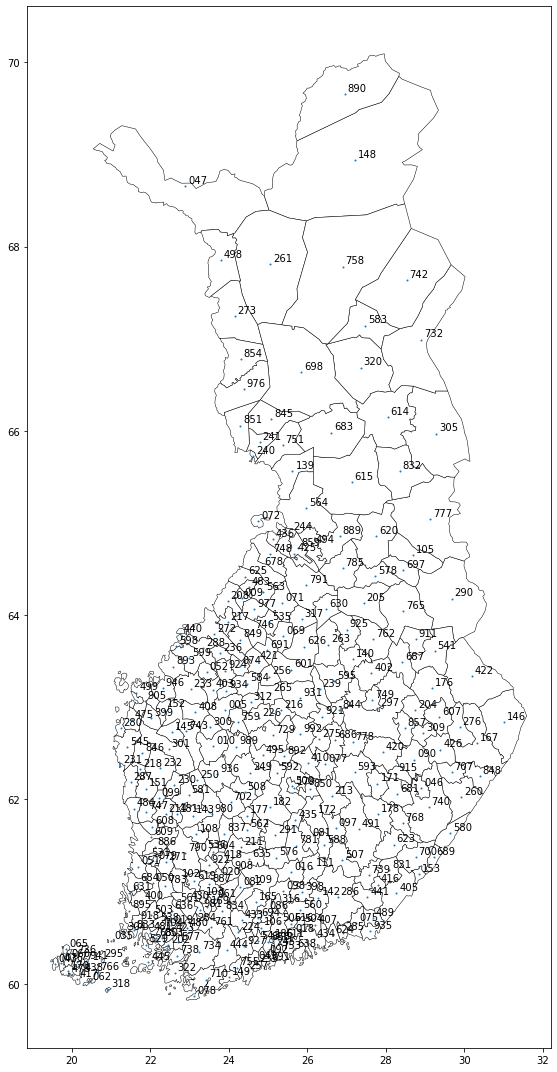

In [9]:
annote = True#False
ax = gdf_municipality.plot(figsize=(24, 15), facecolor='white', edgecolor='black', linewidth=0.5)
gdf_municipality_centroid.plot(ax=ax, markersize=1)
if annote:
    for x, y, label in zip(gdf_municipality_centroid.lon,gdf_municipality_centroid.lat, gdf_municipality_centroid.code):
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.tight_layout()


In [10]:
def format_timestamp(date, hour_bin):
    return '%s %s:00:00' % (date, hour_bin[:2])

In [11]:
if not os.path.isfile('../data/municipality_mobility.zip'):
    df_od = []
    # load several csv files, then merge those file into one dataframe
    df_od.append(pd.read_csv('../huangz4/masterdata/GSE/GSE_od_muni_2019_2020.csv'))   
    df_od.append(pd.read_csv('../huangz4/masterdata/GSE/GSE_od_muni_2019_2020_4_5.csv'))
    df_od = pd.concat(df_od)

    df_od['timestamp'] = df_od.apply(lambda z: format_timestamp(z.date, z.hour_bin), axis=1)
    df_od['timestamp'] = pd.to_datetime(df_od['timestamp'])
    
    df_od.to_csv('../data/municipality_mobility.zip', index=False, compression='zip')
else:
    df_od = pd.read_csv('../data/municipality_mobility.zip', parse_dates=['timestamp'])#../huangz4/masterdata/GSE/

In [12]:
df1 = df_od[df_od.isna().any(axis=1)]
print(df1)
df_od.isna().any()

Empty DataFrame
Columns: [trips_sum, date, origin_muni_code, origin_muni, origin_region_code, origin_region, dest_muni_code, dest_muni, dest_region_code, dest_region, hour_bin, timestamp]
Index: []


trips_sum             False
date                  False
origin_muni_code      False
origin_muni           False
origin_region_code    False
origin_region         False
dest_muni_code        False
dest_muni             False
dest_region_code      False
dest_region           False
hour_bin              False
timestamp             False
dtype: bool

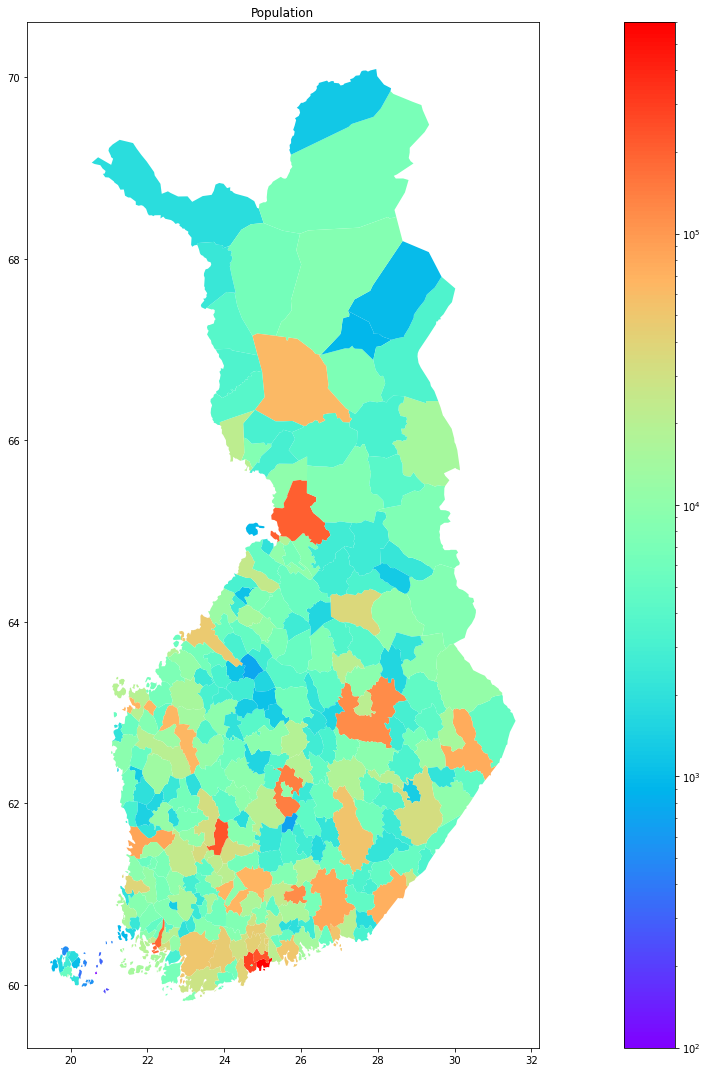

In [13]:
#gdf_municipality = gdf_municipality.to_crs(3857)
ax = gdf_municipality.plot(figsize=(24, 15),
                      column='Population', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=100, vmax=600_000))
ax.set_title("Population")
gdf_municipality = gdf_municipality.to_crs(4326)
plt.tight_layout()
plt.savefig('finland_pop.pdf', bbox_inches='tight')

In [14]:
municipalities = gdf_municipality_centroid['id'].unique()

In [15]:
min_df = gdf_municipality[['code','name']]
municipality_dict = dict(min_df.values)


In [16]:
dict_municipality = {}
for k, v in municipality_dict.items():
    dict_municipality[v] = k

In [17]:
df_feb_weekday2019 = df_od[(df_od.date >= '2019-02-01') & (df_od.date < '2019-03-01') & (df_od.timestamp.dt.weekday < 5)]

In [18]:
df_feb_weekend2019 = df_od[(df_od.date >= '2019-02-01') & (df_od.date < '2019-03-01') & (df_od.timestamp.dt.weekday > 4)]

In [19]:
df_march_weekday2019 = df_od[(df_od.date >= '2019-03-01') & (df_od.date < '2019-04-01') & (df_od.timestamp.dt.weekday < 5)]

In [20]:
df_march_weekend2019 = df_od[(df_od.date >= '2019-03-01') & (df_od.date < '2019-04-01') & (df_od.timestamp.dt.weekday > 4)]

In [21]:
df_april_weekday2019 = df_od[(df_od.date >= '2019-04-01') & (df_od.date < '2019-05-01') & (df_od.timestamp.dt.weekday < 5)]

In [22]:
df_april_weekend2019 = df_od[(df_od.date >= '2019-04-01') & (df_od.date < '2019-05-01') & (df_od.timestamp.dt.weekday > 4)]

In [23]:
df_may_weekday2019 = df_od[(df_od.date >= '2019-05-01') & (df_od.date < '2019-06-01') & (df_od.timestamp.dt.weekday < 5)]

In [24]:
df_may_weekend2019 = df_od[(df_od.date >= '2019-05-01') & (df_od.date < '2019-06-01') & (df_od.timestamp.dt.weekday > 4)]

In [25]:
df_feb_weekday2020 = df_od[(df_od.date >= '2020-02-01') & (df_od.date < '2020-03-01') & (df_od.timestamp.dt.weekday < 5)]

In [26]:
df_feb_weekend2020 = df_od[(df_od.date >= '2020-02-01') & (df_od.date < '2020-03-01') & (df_od.timestamp.dt.weekday > 4)]

In [27]:
df_march_weekday2020 = df_od[(df_od.date >= '2020-03-01') & (df_od.date < '2020-04-01') & (df_od.timestamp.dt.weekday < 5)]

In [28]:
df_march_weekend2020 = df_od[(df_od.date >= '2020-03-01') & (df_od.date < '2020-04-01') & (df_od.timestamp.dt.weekday > 4)]

In [29]:
df_april_weekday2020 = df_od[(df_od.date >= '2020-04-01') & (df_od.date < '2020-05-01') & (df_od.timestamp.dt.weekday < 5)]

In [30]:
df_april_weekend2020 = df_od[(df_od.date >= '2020-04-01') & (df_od.date < '2020-05-01') & (df_od.timestamp.dt.weekday > 4)]

In [31]:
df_may_weekday2020 = df_od[(df_od.date >= '2020-05-01') & (df_od.date < '2020-06-01') & (df_od.timestamp.dt.weekday < 5)]

In [32]:
df_may_weekend2020 = df_od[(df_od.date >= '2020-05-01') & (df_od.date < '2020-06-01') & (df_od.timestamp.dt.weekday > 4)]

In [33]:
df_feb2019 = df_od[(df_od.date >= '2019-02-01') & (df_od.date < '2019-03-01')]
df_march2019 = df_od[(df_od.date >= '2019-03-01') & (df_od.date < '2019-04-01')]
df_april2019 = df_od[(df_od.date >= '2019-04-01') & (df_od.date < '2019-05-01')]
df_may2019 = df_od[(df_od.date >= '2019-05-01') & (df_od.date < '2019-06-01')]
df_feb2020 = df_od[(df_od.date >= '2020-02-01') & (df_od.date < '2020-03-01')]
df_march2020 = df_od[(df_od.date >= '2020-03-01') & (df_od.date < '2020-04-01')]
df_april2020 = df_od[(df_od.date >= '2020-04-01') & (df_od.date < '2020-05-01')]
df_may2020 = df_od[(df_od.date >= '2020-05-01') & (df_od.date < '2020-06-01')]

In [34]:
def df_stastatics(df):
    min_data =  df.trips_sum.min()
    max_data = df.trips_sum.max()
    average = df.trips_sum.mean()
    std_data = df.trips_sum.std()
    total = df.trips_sum.sum()
    return min_data,max_data, round(average,2), round(std_data,2), total

In [35]:
all_dfs = [df_feb_weekday2019,df_feb_weekend2019,df_march_weekday2019,df_march_weekend2019,df_april_weekday2019,df_april_weekend2019,df_may_weekday2019,df_may_weekend2019,
          df_feb_weekday2020,df_feb_weekend2020,df_march_weekday2020,df_march_weekend2020,df_april_weekday2020,df_april_weekend2020,df_may_weekday2020,df_may_weekend2020]

In [36]:
for i,df in enumerate(all_dfs):
    print(i,'*******')
    print(df.trips_sum.isna().any())
    

0 *******
False
1 *******
False
2 *******
False
3 *******
False
4 *******
False
5 *******
False
6 *******
False
7 *******
False
8 *******
False
9 *******
False
10 *******
False
11 *******
False
12 *******
False
13 *******
False
14 *******
False
15 *******
False


In [37]:
for i,df in enumerate(all_dfs):
    print(i,'*******')
    print(df.isna().any())
    

0 *******
trips_sum             False
date                  False
origin_muni_code      False
origin_muni           False
origin_region_code    False
origin_region         False
dest_muni_code        False
dest_muni             False
dest_region_code      False
dest_region           False
hour_bin              False
timestamp             False
dtype: bool
1 *******
trips_sum             False
date                  False
origin_muni_code      False
origin_muni           False
origin_region_code    False
origin_region         False
dest_muni_code        False
dest_muni             False
dest_region_code      False
dest_region           False
hour_bin              False
timestamp             False
dtype: bool
2 *******
trips_sum             False
date                  False
origin_muni_code      False
origin_muni           False
origin_region_code    False
origin_region         False
dest_muni_code        False
dest_muni             False
dest_region_code      False
dest_region           

In [38]:
weekday_dfs = [df_feb_weekday2019,df_march_weekday2019,df_april_weekday2019,df_may_weekday2019,
          df_feb_weekday2020,df_march_weekday2020,df_april_weekday2020,df_may_weekday2020]

In [39]:
weekend_dfs = [df_feb_weekend2019,df_march_weekend2019,df_april_weekend2019,df_may_weekend2019,
          df_feb_weekend2020,df_march_weekend2020,df_april_weekend2020,df_may_weekend2020]

In [40]:
stcs_weekday = []
cnt = 0
for dfs in weekday_dfs:
    cnt += 1
    st = df_stastatics(dfs)
    stcs_weekday.append(st)

In [41]:
stcs_weekend = []
for dfs in weekend_dfs:
    
    st = df_stastatics(dfs)
    stcs_weekend.append(st)

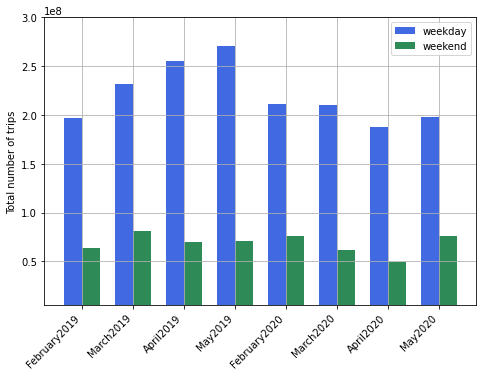

In [42]:
all_means_weekday = [stcs_weekday[i][4] for i in range(8) ]
all_means_weekend = [stcs_weekend[i][4] for i in range(8) ]
tic = ( 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020')
ind = np.arange(8)
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Total number of trips')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
ax.set_ylim([0.5*10**7,3*10**8])
plt.grid(True)

plt.savefig('total_trips.pdf', bbox_inches='tight')

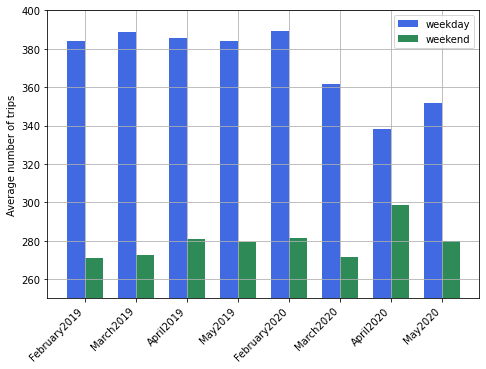

In [43]:
all_means_weekday =  [stcs_weekday[i][2] for i in range(8) ]
all_means_weekend = [stcs_weekend[i][2] for i in range(8) ]
tic = ( 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020')
ind = np.arange(8)
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average number of trips')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
ax.set_ylim([250,400])
plt.grid(True)

plt.savefig('average_trips.pdf', bbox_inches='tight')

In [44]:
def preprocess(df_truth):
    N_days = len(df_truth['date'].unique())
    df_truth = df_truth.groupby(['origin_muni_code', 'dest_muni_code']).trips_sum.sum().to_frame('trips_sum')
    df_truth['trips_sum'] /= N_days
    df_truth['trips_sum'] = df_truth['trips_sum'].astype(int)
    df_truth.reset_index(inplace=True)
    df_truth['origin_muni_code'] = df_truth['origin_muni_code'].apply(lambda z: str(z).zfill(3))
    df_truth['dest_muni_code'] = df_truth['dest_muni_code'].apply(lambda z: str(z).zfill(3))
    df_truth.columns = ['oz', 'dz', 'actual_od']
    return df_truth

In [45]:
def get_signature(df):
    df = df[df['oz'] != df['dz']].copy(True)
    df = df.merge(pd.DataFrame(municipalities, columns=['dz']), on='dz', how='outer')
    df.fillna(0, inplace=True)
    df['norm_od'] = (df['actual_od']-df['actual_od'].min()) / (df['actual_od'].max()-df['actual_od'].min())
    df.sort_values('norm_od', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [46]:
def plot_signature(df_truth,code, title):
    
    select_truth = df_truth[df_truth['oz'] == code]
    signature_truth = get_signature(select_truth)

    plt.figure(figsize=(5, 4))   
    plt.plot(signature_truth.index, signature_truth.norm_od, '-')
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.title(title)
    plt.tight_layout()


In [47]:
def plot_compare_signature(df1,df2,code, t1,t2,title):
    
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    
    plt.figure(figsize=(5, 4))   
    plt.plot(signature1.index, signature1.norm_od, '-x', color = 'skyblue',label = t1, alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, '-o',color = 'b',label = t2  ,alpha = 0.5)

    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title(title)
    plt.tight_layout()


In [48]:
def plot_signature_all(df):
    plt.figure(figsize=(8, 6))
    selected_cities_code = ['049','091','092','698','564','837','853','297']
    selected_cities_name = [municipality_dict[c] for c in selected_cities_code]
    
    for code,city_name in zip(selected_cities_code,selected_cities_name):
        select = df[df['oz'] == code]
        signature = get_signature(select)
        plt.plot(signature.index, signature.norm_od, '-', alpha=0.75, label = city_name)
        
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.tight_layout()
    
   

In [121]:
def plot_signature_selected():
    plt.figure(figsize=(12, 6))
    selected_cities_code = ['049','091','092','698','564','837','853','297']
    selected_cities_name = [municipality_dict[c] for c in selected_cities_code]
    
    plt.subplot(2, 2, 1)
    for code,city_name in zip(selected_cities_code,selected_cities_name):
        
        df = preprocess(df_feb2020)
        select = df[df['oz'] == code]
        signature = get_signature(select)
        plt.plot(signature.index, signature.norm_od, '-', alpha=0.75, label = city_name)
        plt.title('February 2020')
        plt.yscale('log')
        plt.xlabel('Rank')
        plt.ylabel('Fraction (%)')
        plt.legend()
        plt.tight_layout()
    
    
    plt.subplot(2, 2, 2)
    for code,city_name in zip(selected_cities_code,selected_cities_name):
        
        df = preprocess(df_march2020)
        select = df[df['oz'] == code]
        signature = get_signature(select)
        plt.plot(signature.index, signature.norm_od, '-', alpha=0.75, label = city_name)
        plt.title('March 2020')
        plt.yscale('log')
        plt.xlabel('Rank')
        plt.ylabel('Fraction (%)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'../plots2/select_citis.pdf', bbox_inches='tight')
    

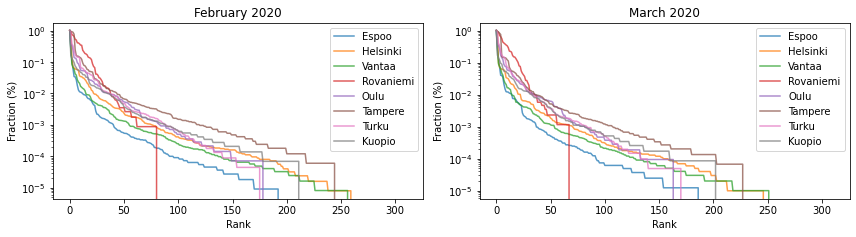

In [122]:
plot_signature_selected()

In [124]:
def plot_signature_map(df, code, title):
    select = df[df['oz'] == code]
    select_signature = get_signature(select)
    select_signature = gdf_municipality.merge(select_signature, left_on='code', right_on='dz')

    ax = gdf_municipality.plot(figsize=(9, 12), facecolor='white', edgecolor='grey')
    select_signature.plot(ax=ax,
                          column='norm_od', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.0001, vmax=0.5))
    select_signature[select_signature['code'] == code].plot(ax=ax, color='black')
    ax.set_title('%s' % title)


In [125]:
def plot_compare_all_signature_weekday(city_name,code):   
    plt.figure(figsize=(10, 10))
    plt.suptitle(r"$\bf{" + str(city_name) + "}$", fontsize=16)
    plt.subplot(2, 2, 1)
    df1 = preprocess(df_feb_weekday2020)
    df2 = preprocess(df_feb_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.norm_od, '-x', color = 'skyblue',label = '2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, '-o',color = 'b',label = '2019'  ,alpha = 0.5)
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('Feb weekday')
    plt.tight_layout()


    plt.subplot(2, 2, 2)
    df1 = preprocess(df_march_weekday2020)
    df2 = preprocess(df_march_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.norm_od, '-x', color = 'skyblue',label = '2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, '-o',color = 'b',label = '2019'  ,alpha = 0.5)
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('March weekday')
    plt.tight_layout()


    plt.subplot(2, 2, 3)
    df1 = preprocess(df_april_weekday2020)
    df2 = preprocess(df_april_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.norm_od, '-x', color = 'skyblue',label = '2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, '-o',color = 'b',label = '2019'  ,alpha = 0.5)
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('April weekday')
    plt.tight_layout()


    plt.subplot(2, 2, 4)
    df1 = preprocess(df_may_weekday2020)
    df2 = preprocess(df_may_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.norm_od, '-x', color = 'skyblue',label = '2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, '-o',color = 'b',label = '2019'  ,alpha = 0.5)
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('May weekday')
    plt.tight_layout()


In [126]:
def plot_compare_all_signature_oneplot_notscalled(city_name,code):   
    plt.figure(figsize=(8,4))
    plt.suptitle(r"$\bf{" + str(city_name)+ "}$", fontsize=16)
    plt.subplot(1, 2, 1)
    df1 = preprocess(df_feb_weekday2020)
    df2 = preprocess(df_feb_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'b',label = 'February 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od,color = 'b',label = 'February 2019' , alpha = 0.5 )
    
    df1 = preprocess(df_march_weekday2020)
    df2 = preprocess(df_march_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'BlueViolet',label = ' March 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od,color = 'BlueViolet',label = 'March 2019', alpha = 0.5)
   

    df1 = preprocess(df_april_weekday2020)
    df2 = preprocess(df_april_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'DodgerBlue',label = 'April 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od,color = 'DodgerBlue',label = 'April 2019', alpha = 0.5 )
    
    df1 = preprocess(df_may_weekday2020)
    df2 = preprocess(df_may_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'Violet',label = 'May 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od,color = 'Violet',label = 'May 2019', alpha = 0.5 )
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Number of trips')
    plt.legend()
    plt.title('Weekday', fontsize=16)
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    df1 = preprocess(df_feb_weekend2020)
    df2 = preprocess(df_feb_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'b',label = 'February 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od,color = 'b',label = 'February 2019' , alpha = 0.5 )
    
    df1 = preprocess(df_march_weekend2020)
    df2 = preprocess(df_march_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'BlueViolet',label = ' March 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od, color = 'BlueViolet',label = 'March 2019' , alpha = 0.5)
    
    
    df1 = preprocess(df_april_weekend2020)
    df2 = preprocess(df_april_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.actual_od, '-.',color = 'DodgerBlue',label = 'April 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od,color = 'DodgerBlue',label = 'April 2019' , alpha = 0.5)
    
    df1 = preprocess(df_may_weekend2020)
    df2 = preprocess(df_may_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.actual_od, '-.', color = 'Violet',label = 'May 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.actual_od, color = 'Violet',label = 'May 2019' , alpha = 0.5 )
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Number of trips')
    plt.legend()
    plt.title('Weekend', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../plots2/f_{city_name}_notscaled.pdf', bbox_inches='tight')

   

In [127]:
def plot_compare_all_signature_oneplot(city_name,code):   
    plt.figure(figsize=(8,4))
    plt.suptitle(r"$\bf{" + str(city_name)+ "}$", fontsize=16)
    plt.subplot(1, 2, 1)
    df1 = preprocess(df_feb_weekday2020)
    df2 = preprocess(df_feb_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'b',label = 'February 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od,color = 'b',label = 'February 2019' , alpha = 0.5 )
    
    df1 = preprocess(df_march_weekday2020)
    df2 = preprocess(df_march_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'BlueViolet',label = ' March 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od,color = 'BlueViolet',label = 'March 2019', alpha = 0.5)
   

    df1 = preprocess(df_april_weekday2020)
    df2 = preprocess(df_april_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.norm_od, '-.',color = 'DodgerBlue',label = 'April 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od,color = 'DodgerBlue',label = 'April 2019', alpha = 0.5 )
    
    df1 = preprocess(df_may_weekday2020)
    df2 = preprocess(df_may_weekday2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'Violet',label = 'May 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od,color = 'Violet',label = 'May 2019', alpha = 0.5 )
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('Weekday', fontsize=16)
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    df1 = preprocess(df_feb_weekend2020)
    df2 = preprocess(df_feb_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'b',label = 'February 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, color = 'b',label = 'February 2019' , alpha = 0.5 )
    
    df1 = preprocess(df_march_weekend2020)
    df2 = preprocess(df_march_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)

    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'BlueViolet',label = ' March 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, color = 'BlueViolet',label = 'March 2019', alpha = 0.5 )
   

    df1 = preprocess(df_april_weekend2020)
    df2 = preprocess(df_april_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'DodgerBlue',label = 'April 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, color = 'DodgerBlue',label = 'April 2019', alpha = 0.5 )
    
    df1 = preprocess(df_may_weekend2020)
    df2 = preprocess(df_may_weekend2019)
    select1 = df1[df1['oz'] == code]
    signature1 = get_signature(select1)
    select2 = df2[df2['oz'] == code]
    signature2 = get_signature(select2)
    plt.plot(signature1.index, signature1.norm_od, '-.', color = 'Violet',label = 'May 2020', alpha = 0.5)
    plt.plot(signature2.index, signature2.norm_od, color = 'Violet',label = 'May 2019' , alpha = 0.5 )
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.legend()
    plt.title('Weekend', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../plots2/{city_name}_signiture.pdf', bbox_inches='tight')


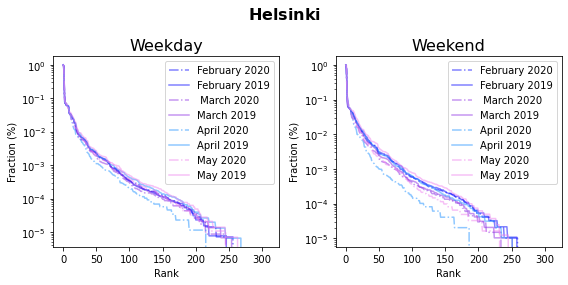

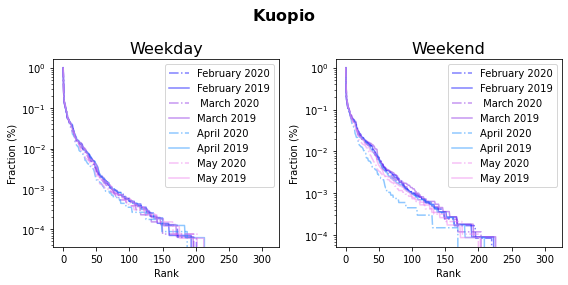

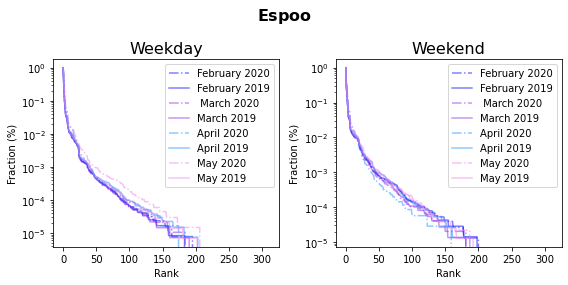

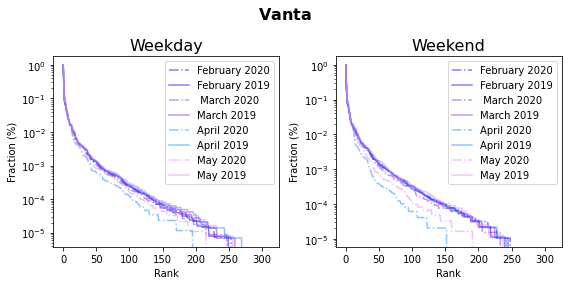

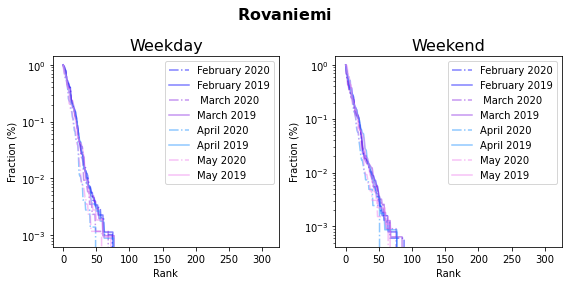

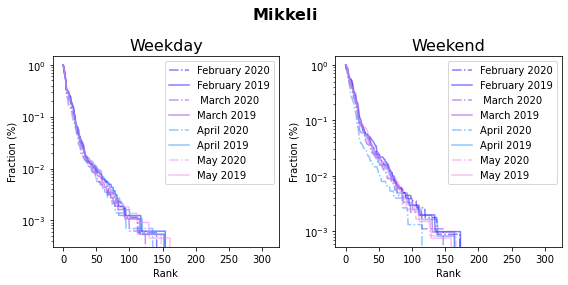

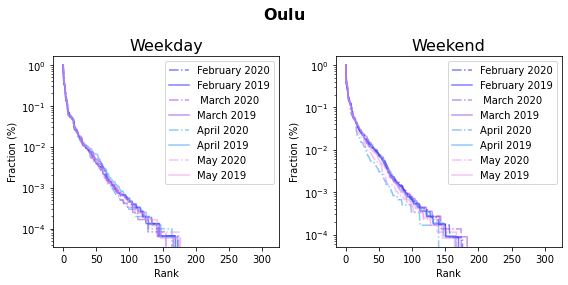

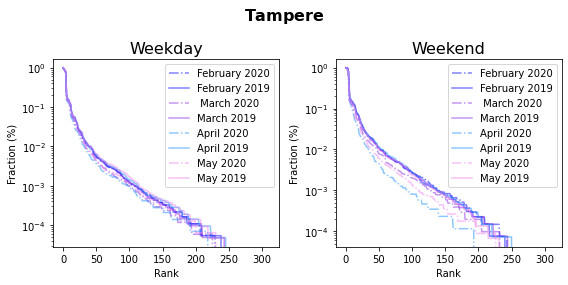

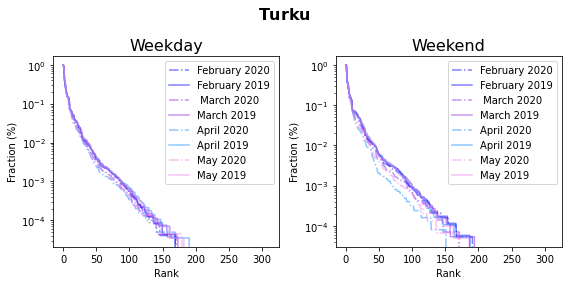

In [128]:
plot_compare_all_signature_oneplot('Helsinki ','091')
plot_compare_all_signature_oneplot('Kuopio','297')
plot_compare_all_signature_oneplot('Espoo','049')
plot_compare_all_signature_oneplot('Vanta', '092')
plot_compare_all_signature_oneplot('Rovaniemi','698')
plot_compare_all_signature_oneplot('Mikkeli','491') 
plot_compare_all_signature_oneplot('Oulu','564')
plot_compare_all_signature_oneplot('Tampere','837')
plot_compare_all_signature_oneplot('Turku','853')


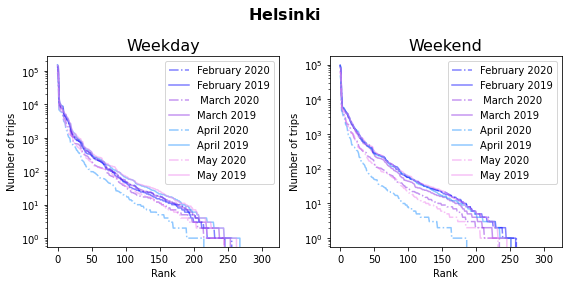

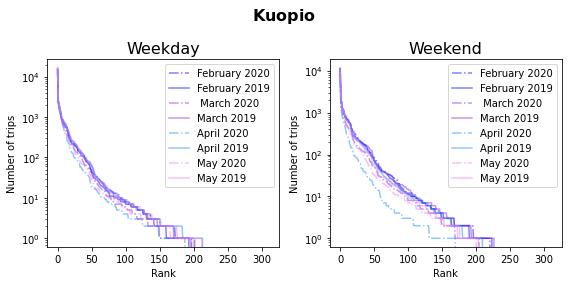

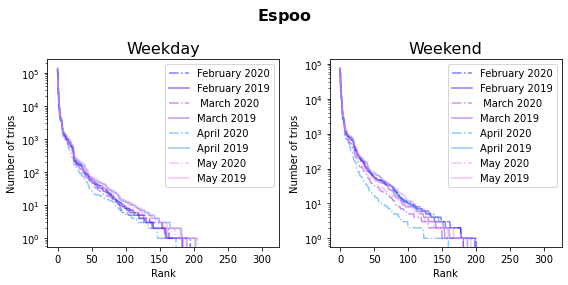

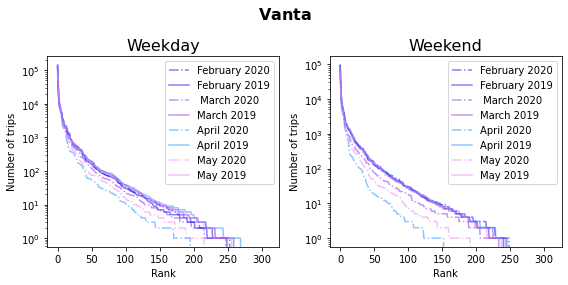

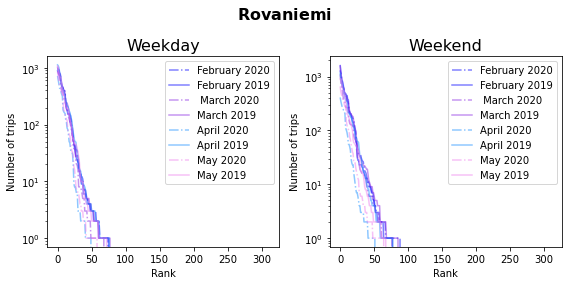

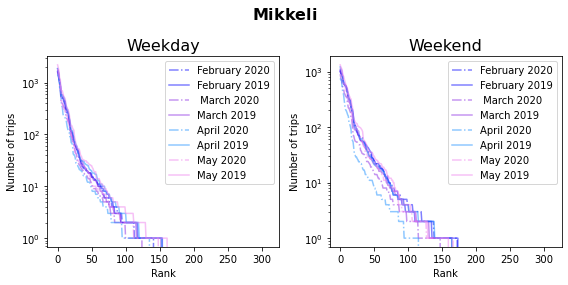

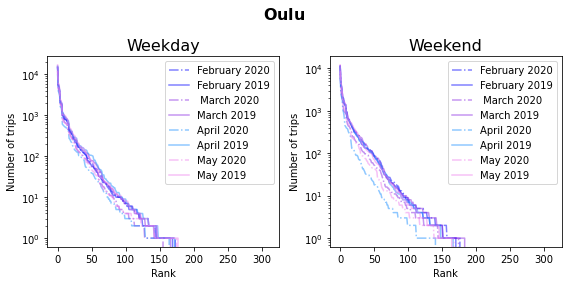

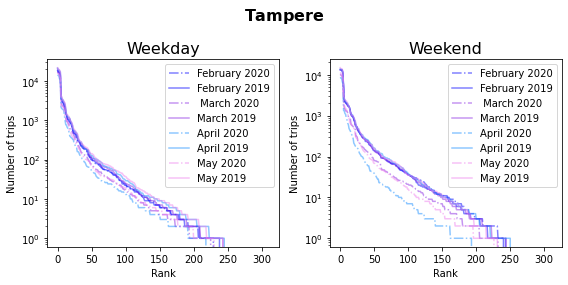

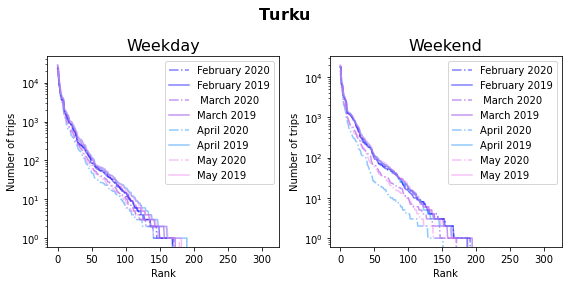

In [129]:
plot_compare_all_signature_oneplot_notscalled('Helsinki ','091')
plot_compare_all_signature_oneplot_notscalled('Kuopio','297')
plot_compare_all_signature_oneplot_notscalled('Espoo','049')
plot_compare_all_signature_oneplot_notscalled('Vanta', '092')
plot_compare_all_signature_oneplot_notscalled('Rovaniemi','698')
plot_compare_all_signature_oneplot_notscalled('Mikkeli','491') 
plot_compare_all_signature_oneplot_notscalled('Oulu','564')
plot_compare_all_signature_oneplot_notscalled('Tampere','837')
plot_compare_all_signature_oneplot_notscalled('Turku','853')


In [130]:
def get_diff_signature(df1,df2):
    df = df1.merge(df2, on='dz', how='outer')

    df['diff'] = (df['actual_od_x']-df['actual_od_x'].min()) / (df['actual_od_x'].max()-df['actual_od_x'].min())- (df['actual_od_y']-df['actual_od_y'].min()) / (df['actual_od_y'].max()-df['actual_od_y'].min())
    
    df = df.merge(pd.DataFrame(municipalities, columns=['dz']), on='dz', how='outer')
    df.fillna(0, inplace=True)
    #df['norm_diff'] = (df['diff']-df['diff'].mean()) / df['diff'].std()
    df.fillna(0, inplace=True)
    df.sort_values('diff', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [131]:
def plot_signature_map_diff(df1,df2, code, title):
    select1 = df1[df1['oz'] == code]
    select2 = df2[df2['oz'] == code]

    select_signature = get_diff_signature(select1,select2)
   # print(select_signature.head())
    select_signature = gdf_municipality.merge(select_signature, left_on='code', right_on='dz')

    ax = gdf_municipality.plot(figsize=(10,14), facecolor='white', edgecolor='grey')
#     select_signature.plot(ax=ax,
#                           column='diff', cmap='rainbow', legend=True,
#                           norm=matplotlib.colors.LogNorm(vmin=10, vmax=300_000))
    select_signature.plot(ax=ax,
                          column='diff', cmap='bwr', legend=True ,vmax=0.002, vmin=-0.002)

    select_signature[select_signature['code'] == code].plot(ax=ax, color='black')
    ax.set_title('%s' % title)

In [137]:
def plot_signature_map_diff_one_city(code,city_name):
    fig, axes = plt.subplots(figsize=(10, 10),ncols=2, nrows=2)
    df1 = preprocess(df_feb_weekday2020)
    df2 = preprocess(df_feb_weekday2019)
    select1 = df1[df1['oz'] == code]
    select2 = df2[df2['oz'] == code]
    select_signature = get_diff_signature(select1,select2)
    select_signature = gdf_municipality.merge(select_signature, left_on='code', right_on='dz')
    ax = gdf_municipality.plot(ax = axes[0][0], facecolor='white', edgecolor='grey')
    select_signature.plot(ax=ax,
                          column='diff', cmap='bwr', legend=True ,vmax=0.002, vmin=-0.002)

    select_signature[select_signature['code'] == code].plot(ax=ax, color='black')
    ax.set_title('February')
    plt.tight_layout()

    #######################################################################
    df1 = preprocess(df_march_weekday2020)
    df2 = preprocess(df_march_weekday2019)
    select1 = df1[df1['oz'] == code]
    select2 = df2[df2['oz'] == code]
    select_signature = get_diff_signature(select1,select2)
    select_signature = gdf_municipality.merge(select_signature, left_on='code', right_on='dz')
    ax = gdf_municipality.plot(ax = axes[0][1], facecolor='white', edgecolor='grey')
    select_signature.plot(ax=ax,
                          column='diff', cmap='bwr', legend=True ,vmax=0.002, vmin=-0.002)

    select_signature[select_signature['code'] == code].plot(ax=ax, color='black')
    ax.set_title('March')
    plt.tight_layout()

    #######################################################################
    df1 = preprocess(df_april_weekday2020)
    df2 = preprocess(df_april_weekday2019)
    select1 = df1[df1['oz'] == code]
    select2 = df2[df2['oz'] == code]
    select_signature = get_diff_signature(select1,select2)
    select_signature = gdf_municipality.merge(select_signature, left_on='code', right_on='dz')
    ax = gdf_municipality.plot(ax = axes[1][0], facecolor='white', edgecolor='grey')
    select_signature.plot(ax=ax,
                          column='diff', cmap='bwr', legend=True ,vmax=0.002, vmin=-0.002)

    select_signature[select_signature['code'] == code].plot(ax=ax, color='black')
    ax.set_title('April')
    plt.tight_layout()

    #######################################################################
    df1 = preprocess(df_may_weekday2020)
    df2 = preprocess(df_may_weekday2019)
    select1 = df1[df1['oz'] == code]
    select2 = df2[df2['oz'] == code]
    select_signature = get_diff_signature(select1,select2)
    select_signature = gdf_municipality.merge(select_signature, left_on='code', right_on='dz')
    ax = gdf_municipality.plot(ax = axes[1][1], facecolor='white', edgecolor='grey')
    select_signature.plot(ax=ax,
                          column='diff', cmap='bwr', legend=True ,vmax=0.002, vmin=-0.002)

    select_signature[select_signature['code'] == code].plot(ax=ax, color='black')
    ax.set_title('May')
    plt.tight_layout()

    fig.suptitle(r"$\bf{" + str(city_name)+ "}$", y=1.01,fontsize=16)
    
    plt.savefig(f'../plots2/diff_{city_name}.pdf', bbox_inches='tight')



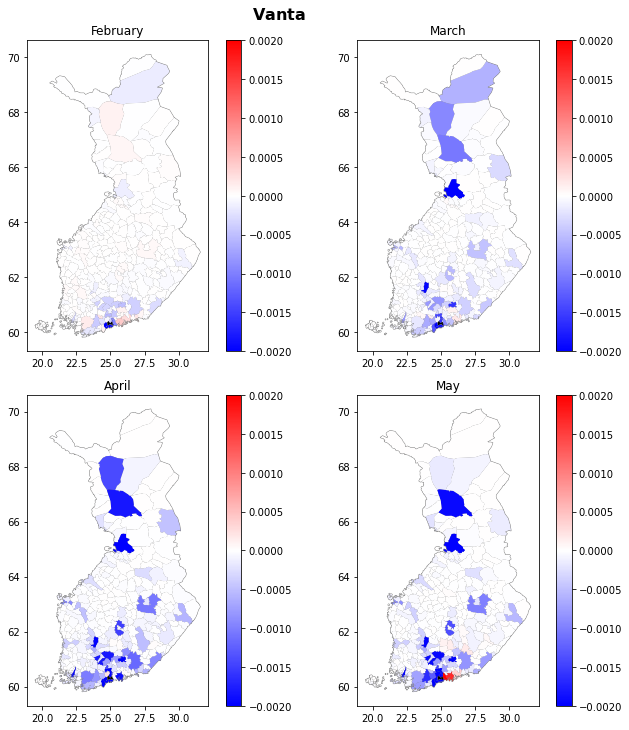

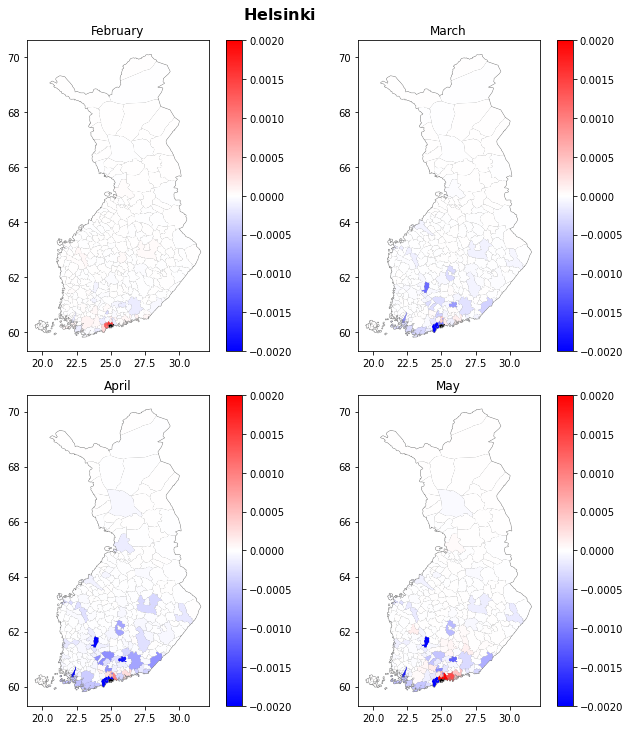

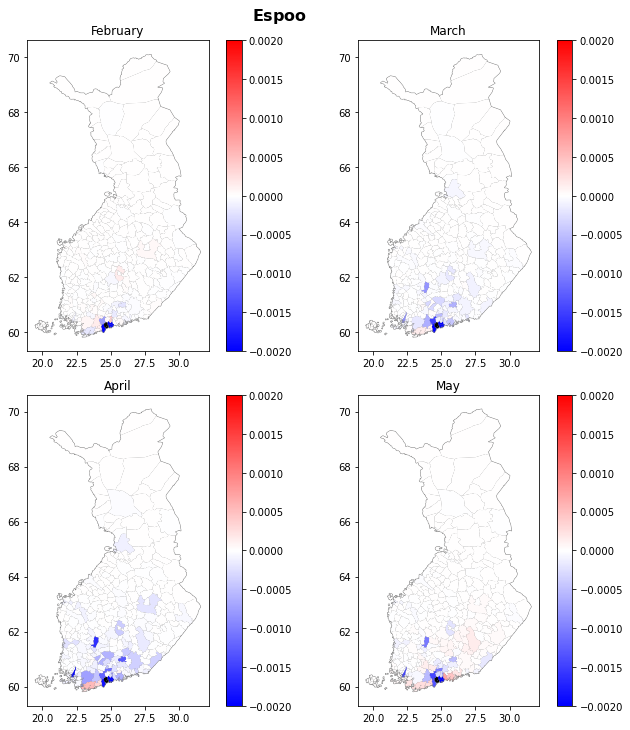

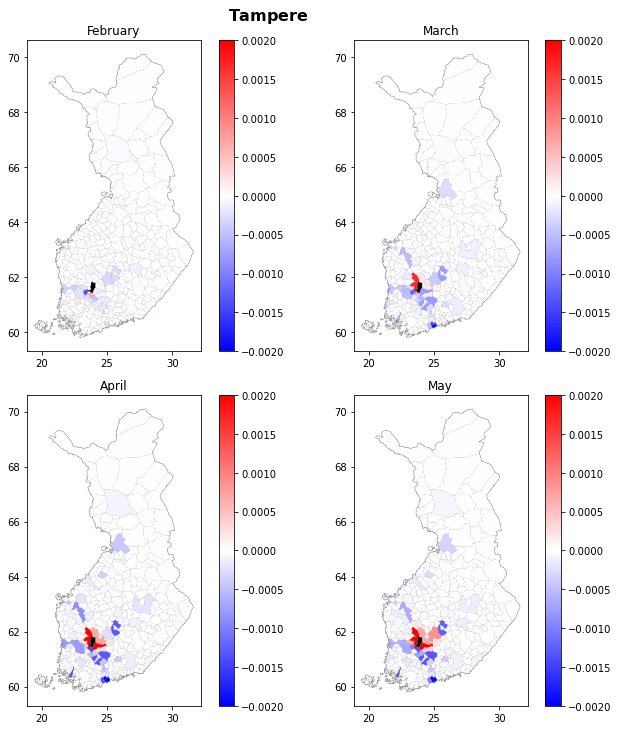

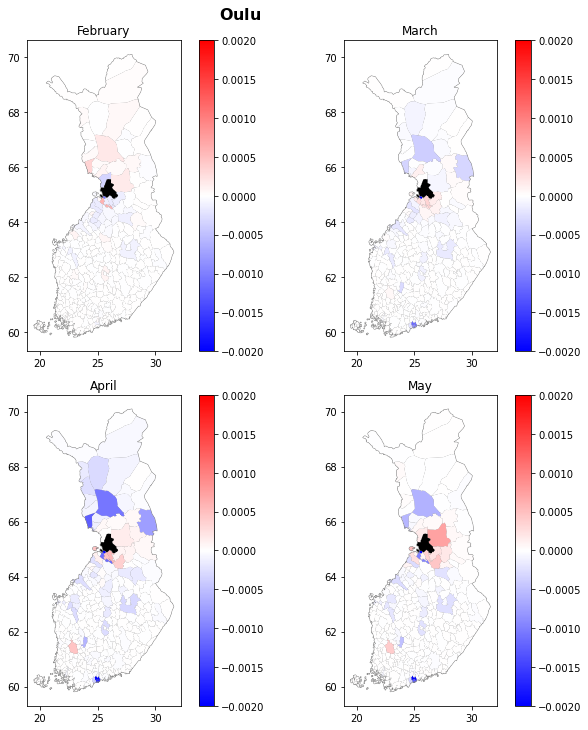

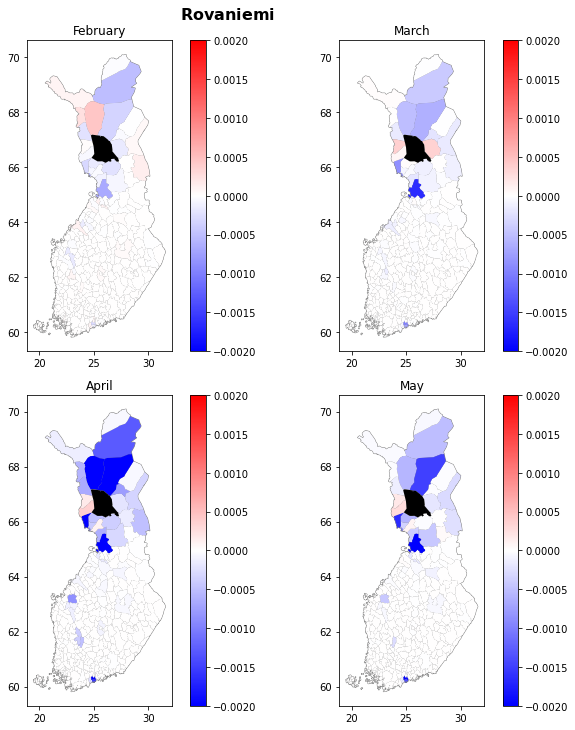

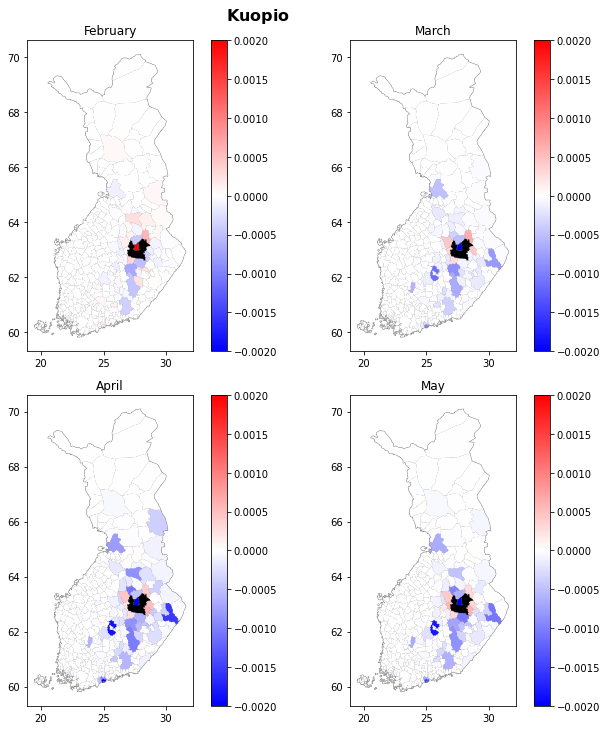

In [140]:
plot_signature_map_diff_one_city('092', 'Vanta')
plot_signature_map_diff_one_city('091', 'Helsinki')
plot_signature_map_diff_one_city('049','Espoo')

plot_signature_map_diff_one_city('837','Tampere')
plot_signature_map_diff_one_city('564','Oulu')

plot_signature_map_diff_one_city('698', 'Rovaniemi')
plot_signature_map_diff_one_city('297', 'Kuopio')


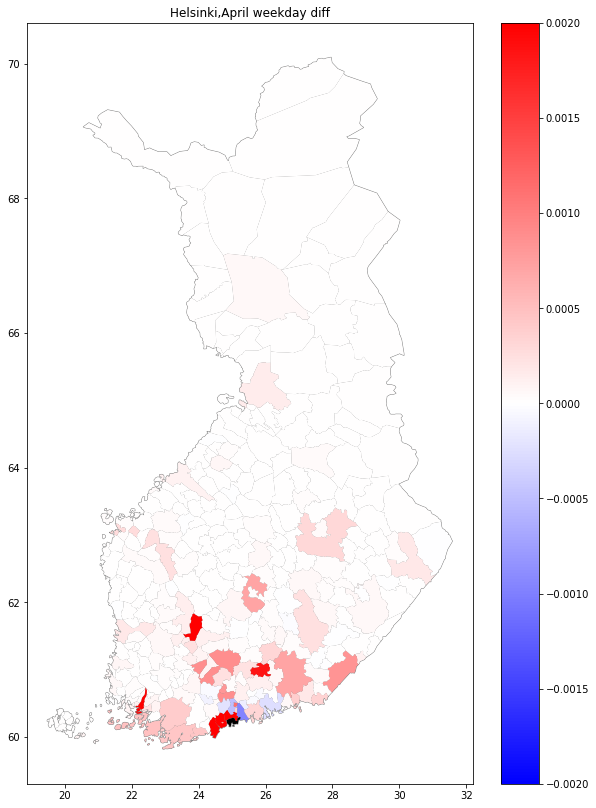

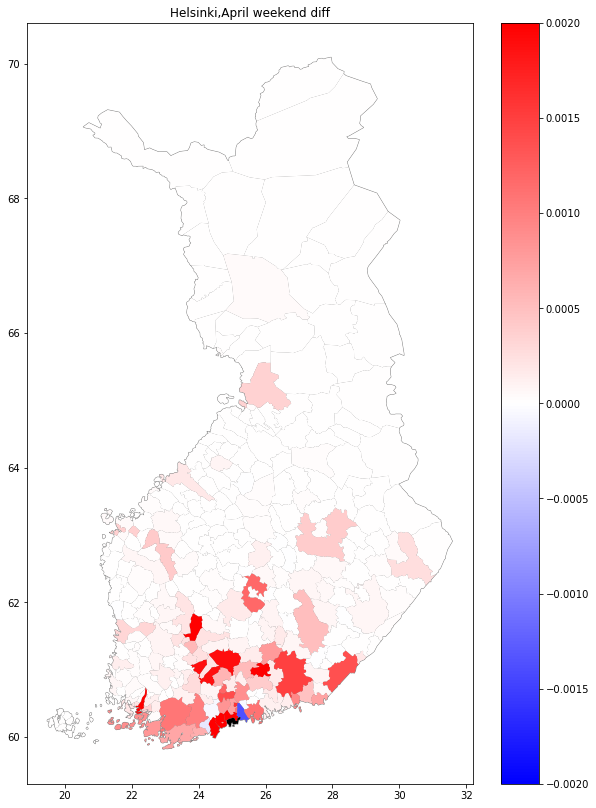

In [142]:
plot_signature_map_diff(preprocess(df_april_weekday2019),preprocess(df_april_weekday2020),'091', 'Helsinki,April weekday diff')
plot_signature_map_diff(preprocess(df_april_weekend2019),preprocess(df_april_weekend2020), '091', 'Helsinki,April weekend diff')

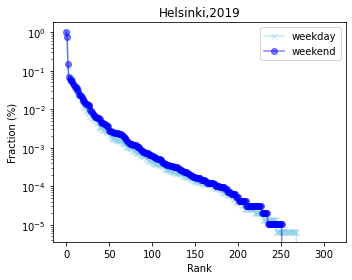

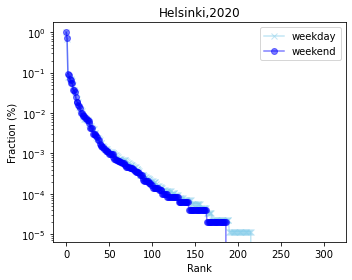

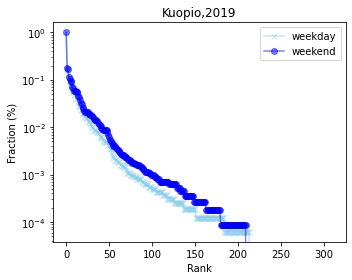

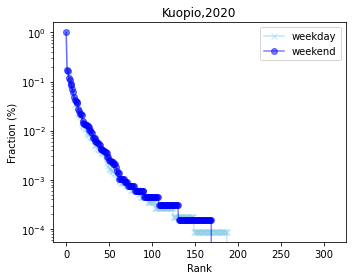

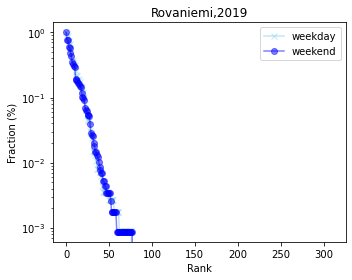

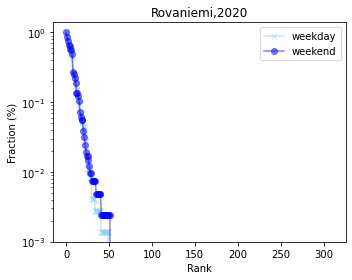

In [143]:
plot_compare_signature(preprocess(df_april_weekday2019),preprocess(df_april_weekend2019),'091', 'weekday','weekend','Helsinki,2019')
plot_compare_signature(preprocess(df_april_weekday2020),preprocess(df_april_weekend2020),'091', 'weekday','weekend','Helsinki,2020')
plot_compare_signature(preprocess(df_april_weekday2019),preprocess(df_april_weekend2019),'297', 'weekday','weekend','Kuopio,2019')
plot_compare_signature(preprocess(df_april_weekday2020),preprocess(df_april_weekend2020),'297', 'weekday','weekend','Kuopio,2020')
plot_compare_signature(preprocess(df_april_weekday2019),preprocess(df_april_weekend2019),'698', 'weekday','weekend','Rovaniemi,2019')
plot_compare_signature(preprocess(df_april_weekday2020),preprocess(df_april_weekend2020),'698', 'weekday','weekend','Rovaniemi,2020')

In [144]:
def get_destino_distribution(df_truth,Origen):
    N_days = len(df_truth['date'].unique())
    df_truth['origin_muni_code'] = df_truth['origin_muni_code'].apply(lambda z: str(z).zfill(3))
    df_truth['dest_muni_code'] = df_truth['dest_muni_code'].apply(lambda z: str(z).zfill(3))
    destino_distribution = df_truth[df_truth.origin_muni_code == Origen].groupby('dest_muni_code').trips_sum.sum().to_frame('actual_od')
    destino_distribution['actual_od'] /= N_days
    destino_distribution['actual_od'] = destino_distribution['actual_od'].astype(int)
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame(municipalities, columns=['dest_muni_code'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='dest_muni_code', how='outer')
    destino_distribution.actual_od.fillna(0, inplace=True)
    destino_distribution['norm_od'] = destino_distribution['actual_od'] / destino_distribution['actual_od'].sum()
    destino_distribution.sort_values('norm_od', ascending=False, inplace=True)
    return destino_distribution

In [145]:
def get_destino_distribution2(df,Origen):
    select_truth = df[df['oz'] == Origen]
    signature_truth = get_signature(select_truth)
    return signature_truth

In [146]:
def plot_signiture(df_truth):
    plt.figure()
    rank = list(range(1,312))
    destino_distributions = {}
    destino_norm_distributions = {}
    for code in municipalities:
        destino_distributions[code] = get_destino_distribution2(df_truth,Origen=code)
        destino_norm_distributions[code] = destino_distributions[code].norm_od
    plt.figure(figsize=(8, 6))
    for code in municipalities:
        destino_distribution = destino_distributions[code]
        plt.plot(rank, destino_distribution.norm_od, color='blue', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Fraction (%)')
    plt.ylim([1e-07, 1e1])
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

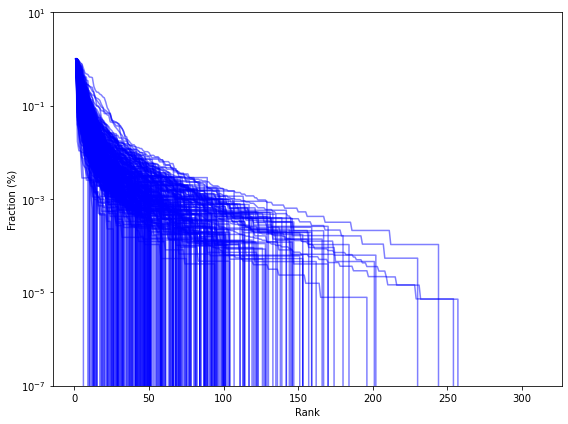

In [147]:
plot_signiture(preprocess(df_feb_weekday2020))

In [148]:
def get_distance_matrix(df_truth):
    destino_distributions = {}
    destino_norm_distributions = {}
    for code in municipalities:
        destino_distributions[code] = get_destino_distribution2(df_truth,Origen=code)
        destino_norm_distributions[code] = destino_distributions[code].norm_od
        
    dist_mat = []
    destino_dist_avg = {}
    for origen_i in municipalities:
        array_i = []
        for origen_j in municipalities:
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    dist_mat = np.nan_to_num(dist_mat, nan=0) 
    return dist_mat

In [149]:
def plot_distance_matrix(dist_mat):
    plt.figure(figsize=(15,15))
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(1,312), [municipality_dict[code] for code in municipalities], rotation=90)
    plt.yticks(range(1,312), [municipality_dict[code] for code in municipalities])
    plt.title('distance matrix')

In [150]:
sort_by_pop = gdf_municipality.sort_values('Population', ascending=False).code.values.tolist()
sort_by_pop_top20 = gdf_municipality.sort_values('Population', ascending=False).code.iloc[:20].values.tolist()

In [151]:
def get_distance_matrix_ordered(df_truth, ordered):
    destino_distributions = {}
    destino_norm_distributions = {}
    for code in municipalities:
        destino_distributions[code] = get_destino_distribution2(df_truth,Origen=code)
        destino_norm_distributions[code] = destino_distributions[code].norm_od
        
    dist_mat = []
    destino_dist_avg = {}
    for origen_i in ordered:
        array_i = []
        for origen_j in ordered:
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    dist_mat = np.nan_to_num(dist_mat, nan=0) 
    return dist_mat

In [152]:
def plot_distance_matrix_ordered(dist_mat, ordered, title, size):
    plt.figure(figsize=size)
    plt.imshow(dist_mat, cmap='Spectral')
    plt.colorbar()
    plt.xticks(range(0,len(ordered)), [municipality_dict[code] for code in ordered], rotation=90)
    plt.yticks(range(0,len(ordered)), [municipality_dict[code] for code in ordered])
    plt.title(title)
    plt.tight_layout()   
    plt.savefig(f'../plots2/{title}.pdf',bbox_inches='tight' )

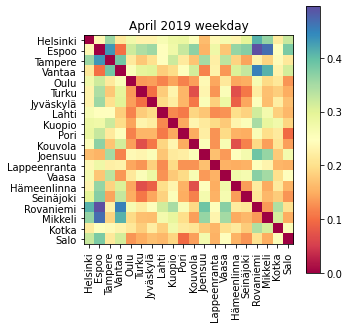

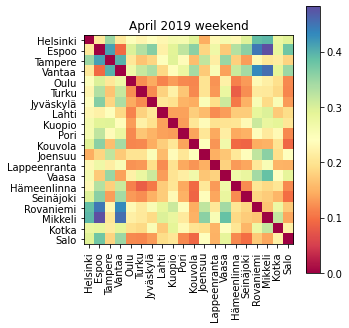

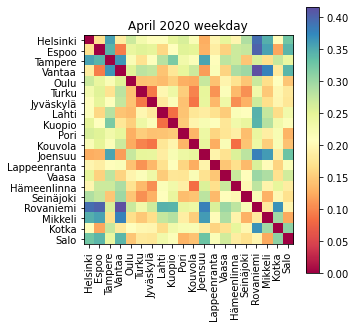

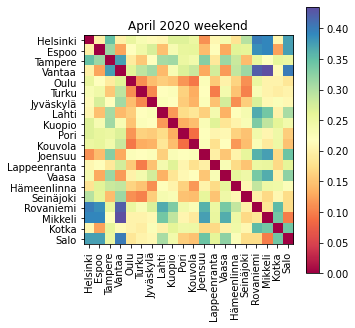

In [153]:
m1 = get_distance_matrix_ordered(preprocess(df_april_weekday2019), sort_by_pop_top20)
m2 = get_distance_matrix_ordered(preprocess(df_april_weekend2019), sort_by_pop_top20)
m3= get_distance_matrix_ordered(preprocess(df_april_weekday2020), sort_by_pop_top20)
m4 = get_distance_matrix_ordered(preprocess(df_april_weekend2020), sort_by_pop_top20)
size = (5, 4.8)
ordered = sort_by_pop_top20
dist_mats = [m1,m2,m3,m4]
titles = ['April 2019 weekday','April 2019 weekend','April 2020 weekday','April 2020 weekend']
for dist_mat,title in zip(dist_mats,titles):
    plot_distance_matrix_ordered(dist_mat, ordered, title, size)

In [154]:
def plot_dendrogram(dist_mat, thr,linkage_method, noplot = False):
    colors = ['Purple','Red','Aqua','DarkGreen','Chocolate','BlueViolet','Chartreuse','Crimson','DarkCyan','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    hierarchy.set_link_color_palette(colors)
    x = linkage(dist_mat,linkage_method)
    if noplot:
        return dendrogram(x, labels= [municipality_dict[code] for code in municipalities], no_plot = True, leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
        
    else: 
        plt.figure(figsize=(20, 5))
        g = dendrogram(x, labels= [municipality_dict[code] for code in municipalities], leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
        plt.axhline(y=thr, ls=':', color='k')
        plt.ylabel("Distance")
        plt.title(f'{linkage_method}')
        plt.tight_layout()

       # plt.savefig(f"{linkage_method}.pdf")
    return g  

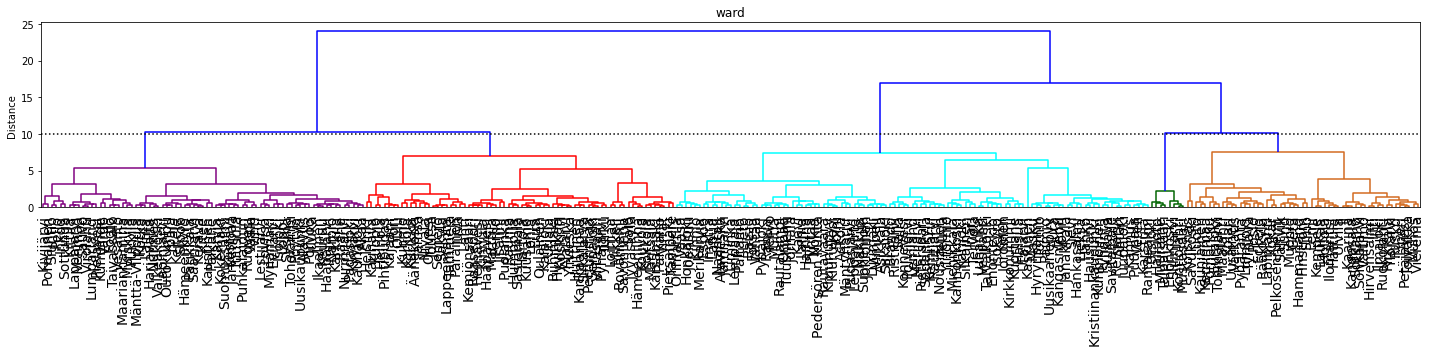

In [108]:
thr = 10
linkage_method = 'ward'
dist_mat = get_distance_matrix(preprocess(df_april_weekday2019))
group = plot_dendrogram(dist_mat, thr,linkage_method, noplot = False)

In [155]:
def plot_clustered_cities(group, title_name, annotate = False):
    #colors = np.unique(group['leaves_color_list']).tolist()
    colors = ['Purple','Red','Aqua','DarkGreen','Chocolate','BlueViolet','Chartreuse','Crimson','DarkCyan','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    group_coord = {}
    for color in color_city_group_dict.keys():
        cities = color_city_group_dict[color]
        group_coord[color] = [list(municipality_dict.keys())[list(municipality_dict.values()).index(city)] for city in cities]   

    ax = gdf_municipality.plot(facecolor='white', edgecolor='black', figsize=(24, 10))
    ax.set_title(title_name)
    for color,coord in group_coord.items() :
        #gdf_municipality_centroid[gdf_municipality_centroid.code.isin(coord)].plot(ax=ax, color=color, legend=True)
        gdf_municipality[gdf_municipality.code.isin(coord)].plot(ax=ax, color=color, alpha=0.5, legend=True)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False,)

    if annotate :    
        for x, y, label in zip(gdf_municipality_centroid.lon,gdf_municipality_centroid.lat, gdf_municipality_centroid.code):
            ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

    plt.tight_layout()
    plt.savefig('../plots2/clusterd_map.pdf',bbox_inches='tight' )



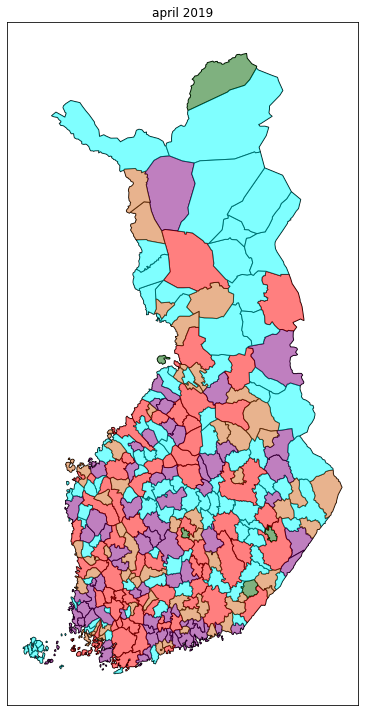

In [156]:
plot_clustered_cities(group, 'april 2019', annotate = False)

In [111]:
def plot_groups(group,df,scale = None):
    group_avg = []
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]
    unique_colors = np.unique(group['leaves_color_list']).tolist()
    num_cluster = len(unique_colors)
    plt.figure(figsize=(5 * num_cluster, 5))  
    for i ,select_group in enumerate(color_city_group_dict.values()):
        plt.subplot(1, num_cluster, i+1)
        arr_avg = np.array([0.0] * 311)
        for name in select_group:
            ine = dict_municipality[name]
            distribution = get_destino_distribution2(df, ine)
            rank = list(range(1, 312))
            plt.bar(rank,distribution.norm_od.tolist(), color=unique_colors[i], alpha=1/len(select_group))
            arr_avg += distribution.norm_od.tolist()
        arr_avg /= len(select_group)

        group_avg.append(arr_avg)
        plt.plot(rank,arr_avg, color='black', ls='--',linewidth=6)
        if scale == 'log':
            plt.yscale('log')
            #plt.ylim([0.00001, 1.1])

        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.xlim([-1, 311])
        plt.title('Cluster %d' % (i+1))
        plt.tight_layout()
    plt.savefig('../plots2/group_plot.pdf',bbox_inches='tight' )
    return group_avg

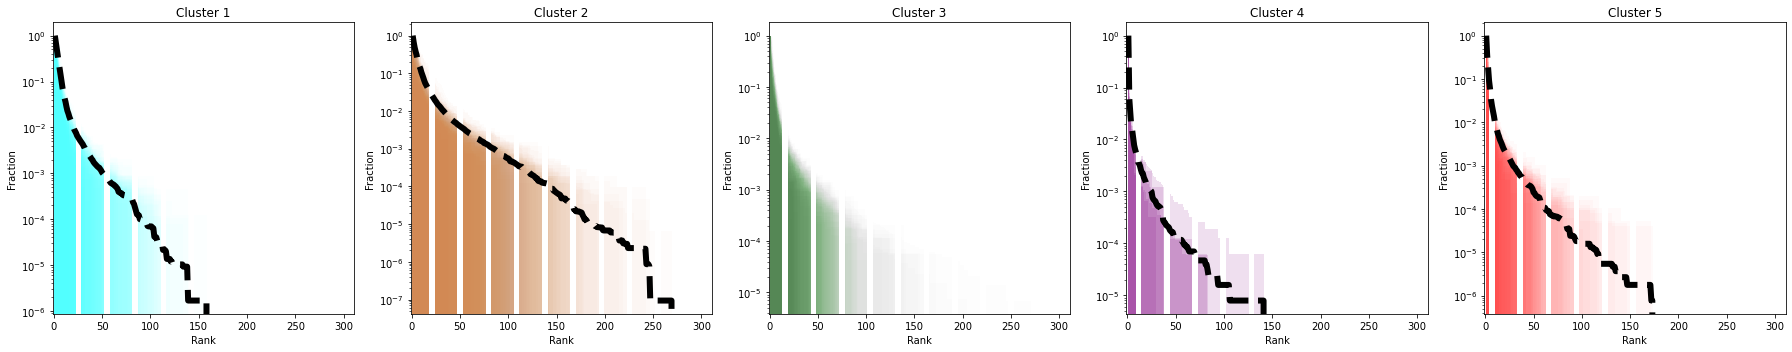

In [112]:
group_avg = plot_groups(group,preprocess(df_april_weekday2019),scale = 'log')

In [113]:
def plot_average_clusters(group,group_avg, scale = None):    
    plt.figure(figsize=(5, 5))
    rank = list(range(1, 312))
    unique_colors = np.unique(group['leaves_color_list']).tolist()

    for i in range(len(group_avg)):
        plt.plot(rank, group_avg[i], color=unique_colors[i], ls='-', label='group %d' % (i+1), alpha = 0.75)
        plt.legend()
        plt.xlabel('Rank')
        plt.ylabel('Fraction')
        plt.title('Average of groups')
        plt.xlim([-1, 312])
        if scale == 'log':
            plt.yscale('log')
        plt.tight_layout()


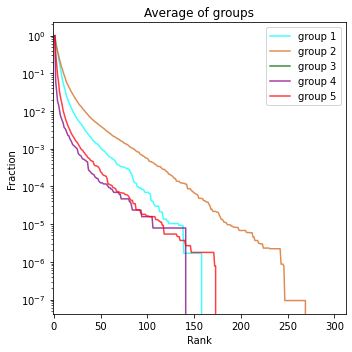

In [114]:
 plot_average_clusters(group,group_avg, scale =  'log')

In [115]:
def get_calinski_dict(dist_mat): 
    calinski_dict = {}
    linkage_methods = ['single' ,'complete' ,'average','weighted','centroid','median','ward']
    thresholds = np.linspace(5,10,5)
    for linkage_method in linkage_methods:
        thr_dict = {}
        for thr in thresholds:
            group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
            labels=group['leaves_color_list']
            if (len(np.unique(group['leaves_color_list'])) > 3):
                dict_temp = {}
                dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
                dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
                thr_dict[thr] =  dict_temp
            else :
                   break
        calinski_dict[linkage_method] = thr_dict

    return calinski_dict

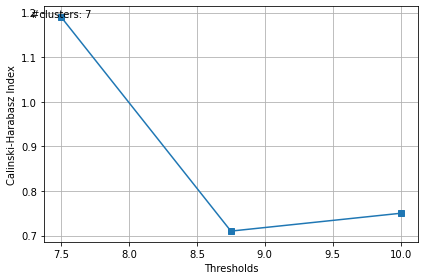

In [116]:
calinski_dict = {}
linkage_method = 'ward'
thresholds = np.linspace(5,10,5)
dist_mat = get_distance_matrix(preprocess(df_feb_weekday2020))
thr_dict = {}
for thr in thresholds:
    group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
    labels=group['leaves_color_list']
    if (len(np.unique(group['leaves_color_list'])) > 3):
        dict_temp = {}
        dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
        dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
        thr_dict[thr] =  dict_temp
    else :
           break
temp_list = []
for thr, v in thr_dict.items():
    if v['Number of clusters: '] < 8:
        temp_list.append((thr,v['Calinski-Harabasz Index: ']))

x, y = zip(*temp_list) 
plt.plot(x, y,'-s')
max_y = max(y)
index = y.index(max_y)
cln = np.squeeze([v['Number of clusters: ']for thr, v in thr_dict.items() if thr == x[index]])
plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')

plt.xlabel('Thresholds')
plt.ylabel('Calinski-Harabasz Index')
#plt.title('Thresholds')
plt.grid(True)
plt.tight_layout()


In [157]:
def plot_CalinskiIndex(calinski_dict, noplot = False):
    best_values = {}
    for inkm,data in calinski_dict.items():
        if len(data)>1:
            temp_list = []
            for thr, v in data.items():
                if v['Number of clusters: '] < 8:
                    temp_list.append((thr,v['Calinski-Harabasz Index: ']))
            if noplot == False :
                x, y = zip(*temp_list) 
                plt.plot(x, y,'-s', label = inkm)
                max_y = max(y)
                index = y.index(max_y)
                cln = np.squeeze([v['Number of clusters: ']for thr, v in data.items() if thr == x[index]])
                plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')
                #plt.plot(x[index],max_y,'*')
                plt.legend()
                plt.xlabel('Thresholds')
                plt.ylabel('Calinski-Harabasz Index')
                #plt.title('Thresholds')
                plt.grid(True)
                plt.tight_layout()
                best_values[inkm]= (x[index],max_y)
                
            else:
                x, y = zip(*temp_list) 
                max_y = max(y)
                index = y.index(max_y)
                best_values[inkm]= (x[index],max_y)
    plt.show()
    return best_values

In [158]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 7):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

In [159]:
def clustering_methods_statastics(best_values_all):
    cluster_methods = []
    for i in range(0, 7):
        cluster_methods.append([k for k,v in best_values_all[i].items() if v == max(best_values_all[i].values(), key=lambda x:x[1])])
        clusters_names, frequencies = [], []
    for each_cluster in cluster_methods:
        if not(each_cluster in frequencies):
            frequencies = frequencies + [each_cluster]
            clusters_names = clusters_names + [[each_cluster, 1]]
        else:
            for index in range(len(clusters_names)):
                if clusters_names[index][0] == each_cluster:
                    clusters_names[index][1] = clusters_names[index][1]+1

    for each in clusters_names:
        print ('{} : {}'.format(*each))

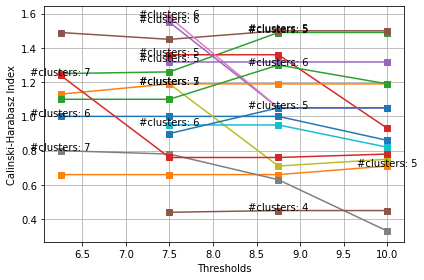

In [160]:
best_values_all = []
calinski_dict_all =[]
for df in all_dfs:
    dist_mat = get_distance_matrix(preprocess(df))
    
    for thr in thresholds:
        group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
        labels=group['leaves_color_list']
        if (len(np.unique(group['leaves_color_list'])) > 3):
            dict_temp = {}
            dict_temp["Number of clusters: "] = len(np.unique(group['leaves_color_list']).tolist())
            dict_temp ["Calinski-Harabasz Index: "] = round(skm.calinski_harabasz_score(dist_mat, labels=labels),2)
            thr_dict[thr] =  dict_temp
        else :
               break
    temp_list = []
    for thr, v in thr_dict.items():
        if v['Number of clusters: '] < 8:
            temp_list.append((thr,v['Calinski-Harabasz Index: ']))
    
    x, y = zip(*temp_list) 
    plt.plot(x, y,'-s')
    max_y = max(y)
    index = y.index(max_y)
    cln = np.squeeze([v['Number of clusters: ']for thr, v in thr_dict.items() if thr == x[index]])
    plt.text(x[index],max_y,f'#clusters: {cln}',ha='center')

    plt.xlabel('Thresholds')
    plt.ylabel('Calinski-Harabasz Index')
    #plt.title('Thresholds')
    plt.grid(True)
    plt.tight_layout()

In [161]:
def get_mobility_network(df):
    gdf_municipality_centroid = gpd.read_file('../data/finland-municipalities-centroids.geojson')
    gdf_municipality_centroid = gdf_municipality_centroid.merge(df_pop[['Population', 'id']], on='id', how='left')
    gdf_municipality_centroid['Population'].fillna(2140, inplace=True)
    gdf_municipality_centroid = gdf_municipality_centroid.to_crs(3857)
    gdf_municipality_centroid['lon'] = gdf_municipality_centroid.apply(lambda z: z.geometry.coords[0][0], axis=1)
    gdf_municipality_centroid['lat'] = gdf_municipality_centroid.apply(lambda z: z.geometry.coords[0][1], axis=1)
    gdf_municipality_centroid = gdf_municipality_centroid.merge(gdf_municipality[['id','code','name']], on=['id'])    
    dict_lon = dict(zip(gdf_municipality_centroid.id, gdf_municipality_centroid.lon))
    dict_lat = dict(zip(gdf_municipality_centroid.id, gdf_municipality_centroid.lat))
    df['origin_muni_code'] = df['origin_muni_code'].apply(lambda z: str(z).zfill(3))
    df['dest_muni_code'] = df['dest_muni_code'].apply(lambda z: str(z).zfill(3))
    mobility_network = df.groupby(['origin_muni_code', 'dest_muni_code', ]).trips_sum.sum().to_frame('flow')
    mobility_network.reset_index(inplace=True)
    mobility_network['norm_flow'] = mobility_network.apply(lambda z: z.flow / mobility_network[mobility_network.origin_muni_code == z.origin_muni_code].flow.sum(), axis=1)
    mobility_network['Origen_lon'] = mobility_network.origin_muni_code.map(dict_lon)
    mobility_network['Origen_lat'] = mobility_network.origin_muni_code.map(dict_lat)
    mobility_network['Destino_lon'] = mobility_network.dest_muni_code.map(dict_lon)
    mobility_network['Destino_lat'] = mobility_network.dest_muni_code.map(dict_lat)
    mobility_network['geometry'] = mobility_network.apply(lambda z: LineString([[z.Origen_lon, z.Origen_lat], [z.Destino_lon, z.Destino_lat]]), axis=1)
    mobility_network = gpd.GeoDataFrame(mobility_network, geometry='geometry')
    mobility_network['length'] = mobility_network.geometry.length / 1000
    return mobility_network

In [162]:
def get_gyration(mobility_network):
    results = []
    for Origen in mobility_network.origin_muni_code.unique():
        select = mobility_network[mobility_network.origin_muni_code == Origen].copy(True)
        results.append([Origen, (select.norm_flow * select.length).mean(), select.length.mean()])
    return results

In [163]:
def plot_network(mobility_network):
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(1, 1, 1)

    dict_lon = dict(zip(gdf_municipality_centroid.id, gdf_municipality_centroid.lon))
    dict_lat = dict(zip(gdf_municipality_centroid.id, gdf_municipality_centroid.lat))
    
    
    g = nx.from_pandas_edgelist(mobility_network, 'origin_muni_code', 'dest_muni_code', ['flow', 'norm_flow'])
    pos = {x: (dict_lon.get(x, 0) , dict_lat.get(x, 0)) for x in set(dict_lat).union(dict_lon)}
    g.add_nodes_from(list(pos.keys()))
    nx.set_node_attributes(g, pos, 'coord')
    
    nx.draw_networkx_nodes(g, pos = nx.get_node_attributes(g , 'coord'), ax = ax,node_size=300,cmap=plt.cm.tab10)

    edgelist = [(u, v) for (u, v, d) in g.edges(data=True)]
    # edges
   # nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
   #                        width=1, alpha=0.5, edge_color='grey')
    durations = [i['norm_flow']*10 for i in dict(g.edges).values()]
    nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
                       width=durations,  edge_color='k')

    # labels
    nx.draw_networkx_labels(g, pos, ax = ax,font_size=12, font_family='Arial')

    plt.gca()
    ax.margins(0.08)
    plt.axis('off')
    plt.tight_layout()
    return g

In [65]:
def get_similarity_matrix(all_dfs):
    all_labels = []
    for df in all_dfs:
        dist_mat = get_distance_matrix(preprocess(df))
        group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
        labels=group['leaves_color_list']
        all_labels.append(labels)
    ARIs = [] 
    for row in all_labels:
        ARI = []
        for row2 in all_labels:
            ARI.append(round(skm.adjusted_rand_score(row,row2),2))
        ARIs.append(ARI)
    return ARIs

In [164]:
def cal_signiture_entropy(df, code):
    df = preprocess(df)
    df['norm_od'] = df['actual_od'] / df['actual_od'].sum()
    df.sort_values('norm_od', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df_signiture = get_destino_distribution2(df, code)
    return entropy(df_signiture.norm_od)/np.log(len(df_signiture.norm_od))

In [165]:
def gini_coefficient(x):
#A Gini coefficient of zero expresses perfect equality, where all values are the same (for example, where everyone has the same income).
#A Gini coefficient of one (or 100%) expresses maximal inequality among values (.g., for a large number of people where only one person 
#has all the income or consumption and all others have none, the Gini coefficient will be nearly one).
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [166]:
def get_gdf_points(results, df):
    gdf_municipality_centroid = gpd.read_file('../data/finland-municipalities-centroids.geojson')
    gdf_municipality_centroid = gdf_municipality_centroid.merge(df_pop[['Population', 'id']], on='id', how='left')
    gdf_municipality_centroid['Population'].fillna(2140, inplace=True)
    gdf_municipality_centroid['lon'] = gdf_municipality_centroid.apply(lambda z: z.geometry.coords[0][0], axis=1)
    gdf_municipality_centroid['lat'] = gdf_municipality_centroid.apply(lambda z: z.geometry.coords[0][1], axis=1)
    df_gyration = pd.DataFrame(results, columns=['id', 'gyration', 'gyration_unweighted'])
    gdf_municipality_centroid = gdf_municipality_centroid.merge(df_gyration, on=['id'])
    gdf_municipality_centroid['signiture_entropy'] = gdf_municipality_centroid.id.apply(lambda z: cal_signiture_entropy(df, z))
    return gdf_municipality_centroid

In [191]:
if not (os.path.isfile('mobility_network_weekdays.pkl') & os.path.isfile('gdf_points_weekdays.pkl')):
    mobility_network_weekdays= []
    weekdays_results = []
    gdf_points_weekdays = []
    for i, df in enumerate(weekday_dfs):
        print(i,30*'*')
        mobility_network = get_mobility_network(df)
        mobility_network_weekdays.append(mobility_network)
        print(20*'+')
        results = []
        for Origen in mobility_network.origin_muni_code.unique():
            select = mobility_network[mobility_network.origin_muni_code == Origen].copy(True)
            results.append([Origen, (select.norm_flow * select.length).mean(), select.length.mean()])
        weekdays_results.append(results)
        print(10*'+')
        gdf_points = get_gdf_points(results, df)
        gdf_points_weekdays.append(gdf_points)
    
    with open('mobility_network_weekdays.pkl','wb') as f:
            pickle.dump(mobility_network_weekdays ,f)

    with open('gdf_points_weekdays.pkl','wb') as f:
            pickle.dump(gdf_points_weekdays ,f)
            
else:
        with open('mobility_network_weekdays.pkl','rb') as f:
            mobility_network_weekdays = pickle.load(f)

        with open('gdf_points_weekdays.pkl','rb') as f:
            gdf_points_weekdays = pickle.load(f)

In [192]:
if not (os.path.isfile('mobility_network_weekend.pkl') & os.path.isfile('gdf_points_weekend.pkl')):

    mobility_network_weekend= []
    weekend_results = []
    gdf_points_weekend = []
    for i, df in enumerate(weekend_dfs):
        print(i,30*'*')
        mobility_network = get_mobility_network(df)
        mobility_network_weekend.append(mobility_network)
        print(20*'+')
        results = []
        for Origen in mobility_network.origin_muni_code.unique():
            select = mobility_network[mobility_network.origin_muni_code == Origen].copy(True)
            results.append([Origen, (select.norm_flow * select.length).mean(), select.length.mean()])
        weekend_results.append(results)
        print(10*'+')
        gdf_points = get_gdf_points(results, df)
        gdf_points_weekend.append(gdf_points)
    
    
    with open('mobility_network_weekend.pkl','wb') as f:
         pickle.dump(mobility_network_weekend,f)

    with open('gdf_points_weekend.pkl','wb') as f:
         pickle.dump(gdf_points_weekend,f)
else:
    with open('mobility_network_weekend.pkl','rb') as f:
        mobility_network_weekend = pickle.load(f)

    with open('gdf_points_weekend.pkl','rb') as f:
        gdf_points_weekend = pickle.load(f)

In [193]:
if not (os.path.isfile('gini_weekday.pkl') & os.path.isfile('gini_weekend.pkl')):

    gini_weekday = []
    for i, df in enumerate(weekday_dfs):
        print(i,30*'*')
        df = preprocess(df)
        gini_results = {}
        for origen in municipalities:
            select_truth = df[df.oz == origen]
            signature_truth = get_destino_distribution2(df,origen)
            g3 = round(gini_coefficient(signature_truth.norm_od),2)
            gini_results[origen] = g3
        gini_weekday.append(gini_results)


    gini_weekend = []
    for i, df in enumerate(weekend_dfs):
        print(i,30*'*')
        df = preprocess(df)
        gini_results = {}
        for origen in municipalities:
            select_truth = df[df.oz == origen]
            signature_truth = get_destino_distribution2(df,origen)
            g3 = round(gini_coefficient(signature_truth.norm_od),2)
            gini_results[origen] = g3
        gini_weekend.append(gini_results)
    
    with open('gini_weekday.pkl','wb') as f:
        pickle.dump(gini_weekday,f)  

    with open('gini_weekend.pkl','wb') as f:
        pickle.dump(gini_weekend,f)

else:
    with open('gini_weekday.pkl','rb') as f:
        gini_weekday = pickle.load(f)  

    with open('gini_weekend.pkl','rb') as f:
        gini_weekend = pickle.load(f)


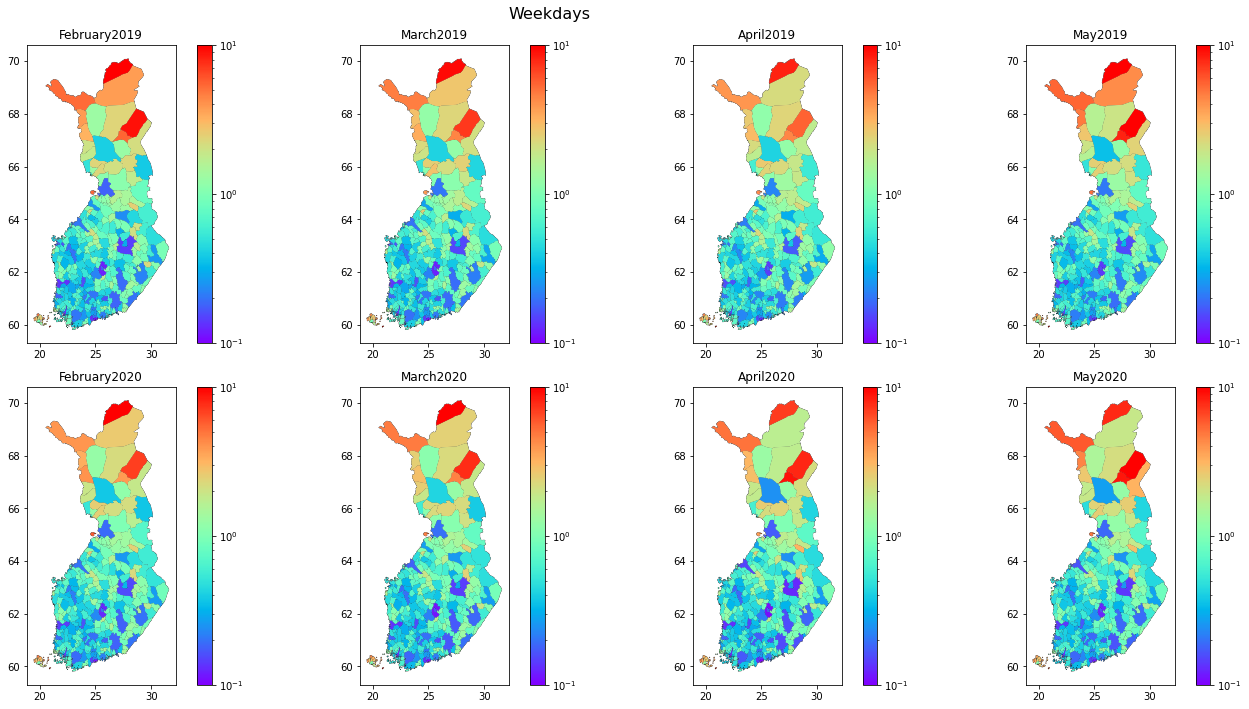

In [194]:
titles = [ 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020']
fig, axes = plt.subplots(figsize=(20, 10),ncols=4, nrows=2)
plt.suptitle("Weekdays", fontsize=16)
for g,title,axe  in zip(gdf_points_weekdays,titles,axes.flat):
    ax = gdf_municipality.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf_municipality.merge(g[['id','gyration']], on=['id'])
    gdf_total['norm_gyration'] = gdf_total.gyration/gdf_total.gyration.mean()
    gdf_total.plot(ax=ax,
                          column='norm_gyration', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=10))#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()


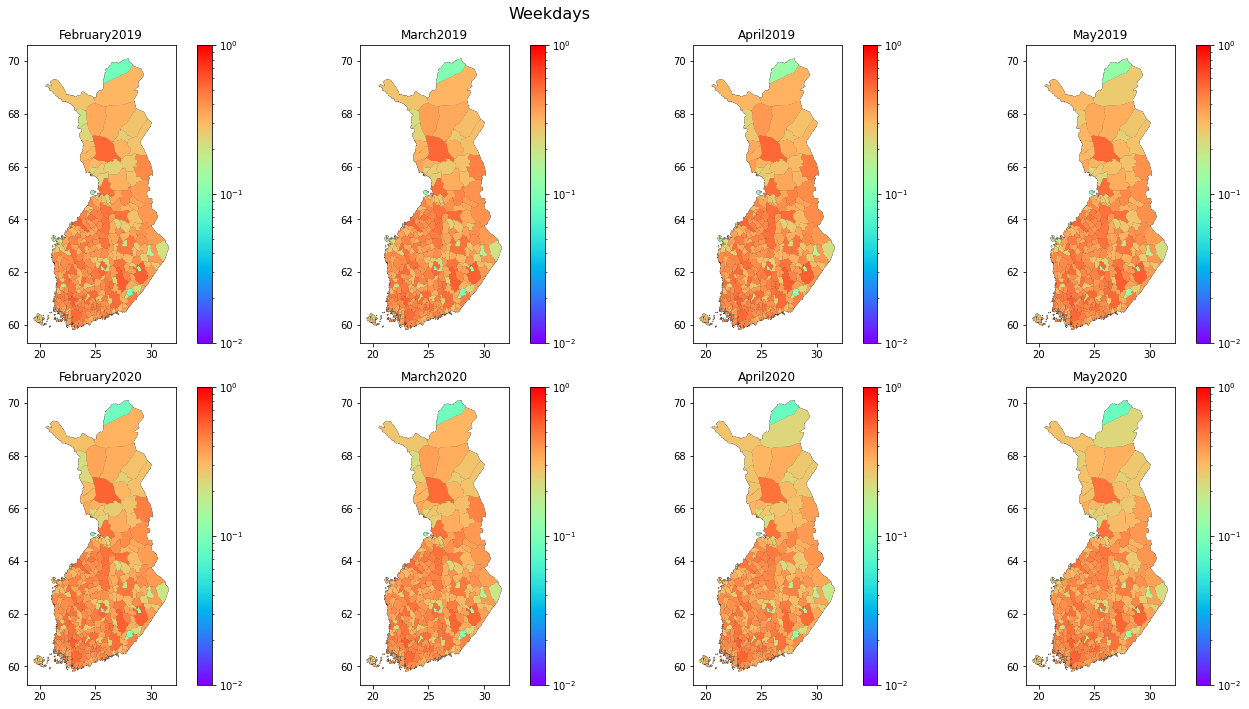

In [195]:
titles = [ 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020']
fig, axes = plt.subplots(figsize=(20, 10),ncols=4, nrows=2)
plt.suptitle("Weekdays", fontsize=16)
for g,title,axe  in zip(gdf_points_weekdays,titles,axes.flat):
    ax = gdf_municipality.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf_municipality.merge(g[['id','signiture_entropy']], on=['id'])
    gdf_total.plot(ax=ax,
                          column='signiture_entropy', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1))#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()


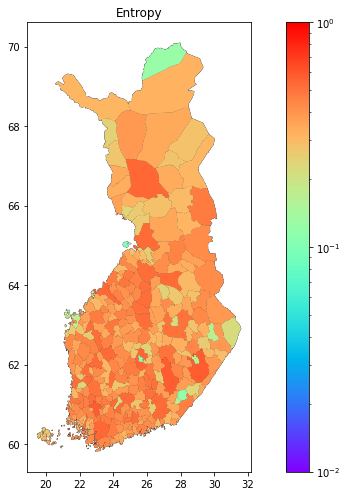

In [91]:
ax = gdf_municipality.plot( figsize=(10, 7),facecolor='white', edgecolor='black', linewidth=0.5)
gdf_total = gdf_municipality.merge(gdf_points_weekdays[2][['id','signiture_entropy']], on=['id'])
gdf_total.plot(ax=ax,
                      column='signiture_entropy', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1))#,alpha=0.5)
ax.set_title('Entropy')
plt.tight_layout()
plt.savefig('../plots2/f_entropy_zone.pdf', bbox_inches='tight')

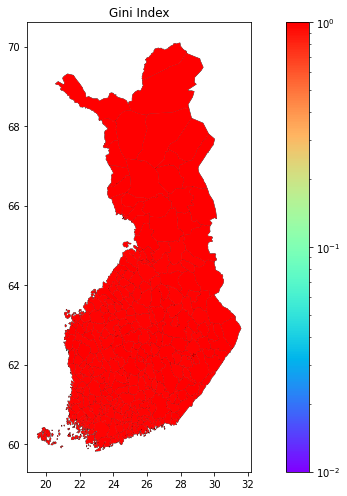

In [92]:
ax = gdf_municipality.plot(figsize=(10, 7), facecolor='white', edgecolor='black', linewidth=0.5)
gini_df =  pd.DataFrame(list(gini_weekday[2].items()), columns = ['id','gini'])
gdf_total = gdf_municipality.merge(gini_df, on=['id'])
gdf_total.plot(ax=ax,
                      column='gini', cmap='rainbow', legend=True,
                      norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1))#, legend_kwds={'shrink': 0.75})#,alpha=0.5)

ax.set_title('Gini Index')
plt.tight_layout()
plt.savefig('../plots2/f_gini_zone.pdf', bbox_inches='tight')

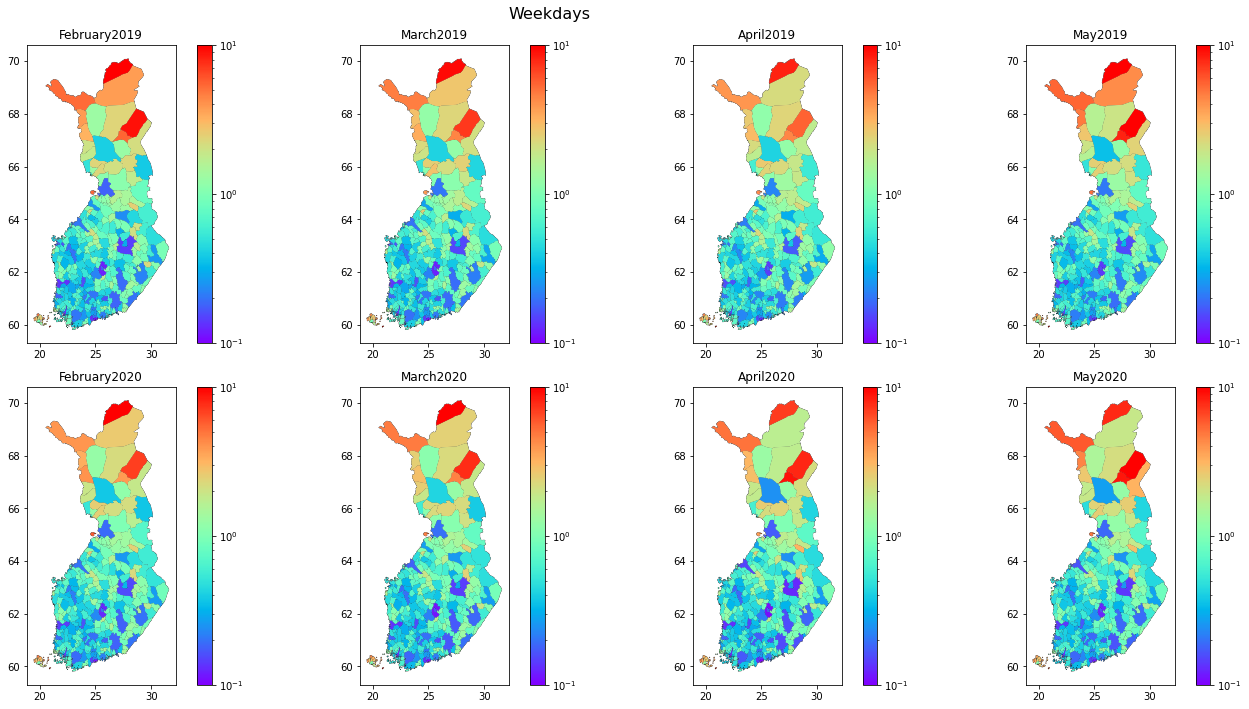

In [93]:
titles = [ 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020']
fig, axes = plt.subplots(figsize=(20, 10),ncols=4, nrows=2)
plt.suptitle("Weekdays", fontsize=16)
for g,title,axe  in zip(gdf_points_weekdays,titles,axes.flat):
    ax = gdf_municipality.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf_municipality.merge(g[['id','gyration']], on=['id'])
    gdf_total['norm_gyration'] = gdf_total.gyration/gdf_total.gyration.mean()
    gdf_total.plot(ax=ax,
                          column='norm_gyration', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=10))#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()


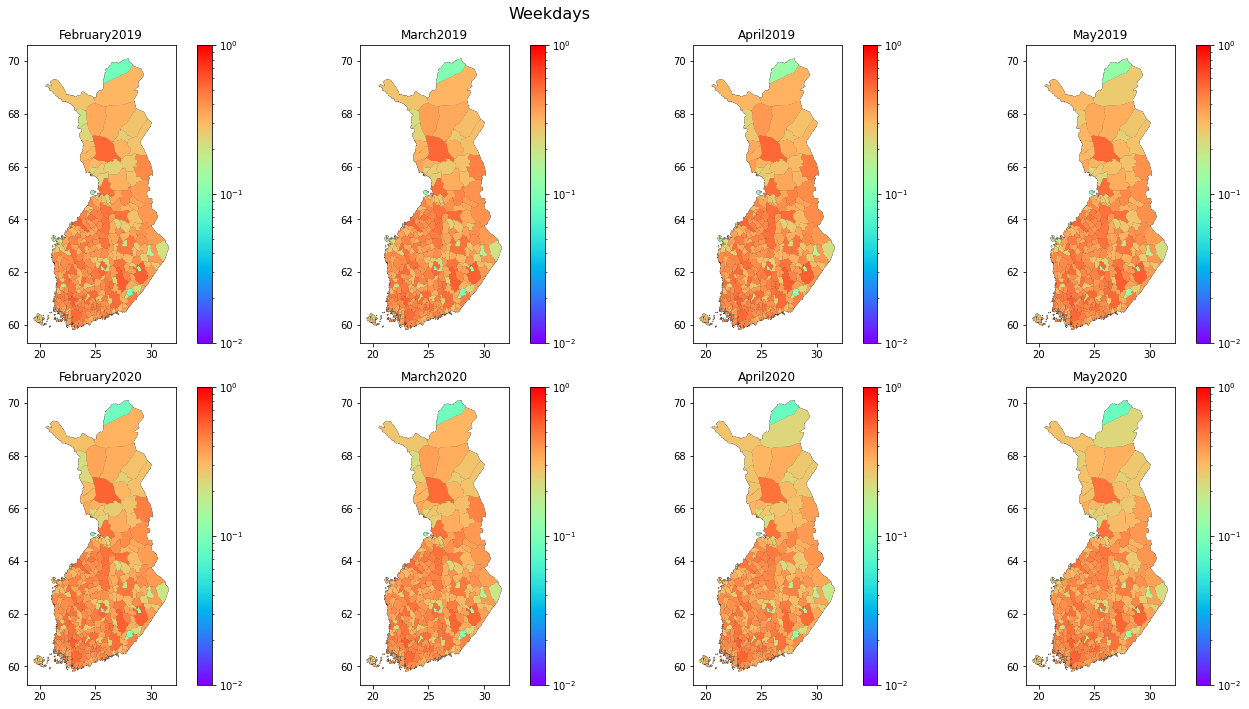

In [196]:
titles = [ 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020']
fig, axes = plt.subplots(figsize=(20, 10),ncols=4, nrows=2)
plt.suptitle("Weekdays", fontsize=16)
for g,title,axe  in zip(gdf_points_weekdays,titles,axes.flat):
    ax = gdf_municipality.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf_municipality.merge(g[['id','signiture_entropy']], on=['id'])
    gdf_total.plot(ax=ax,
                          column='signiture_entropy', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1))#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()


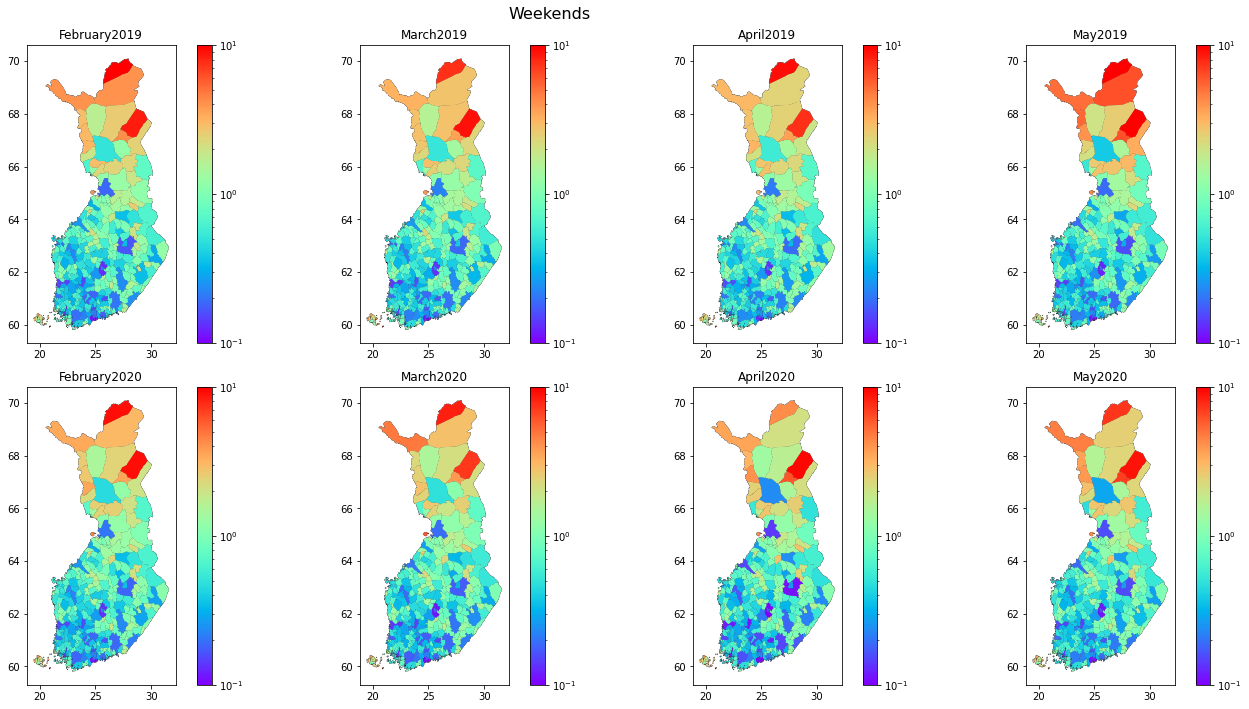

In [95]:
titles = [ 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020']
fig, axes = plt.subplots(figsize=(20, 10),ncols=4, nrows=2)
plt.suptitle("Weekends", fontsize=16)
for g,title,axe  in zip(gdf_points_weekend,titles,axes.flat):
    ax = gdf_municipality.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf_municipality.merge(g[['id','gyration']], on=['id'])
    gdf_total['norm_gyration'] = gdf_total.gyration/gdf_total.gyration.mean()
    gdf_total.plot(ax=ax,
                          column='norm_gyration', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=10))#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()


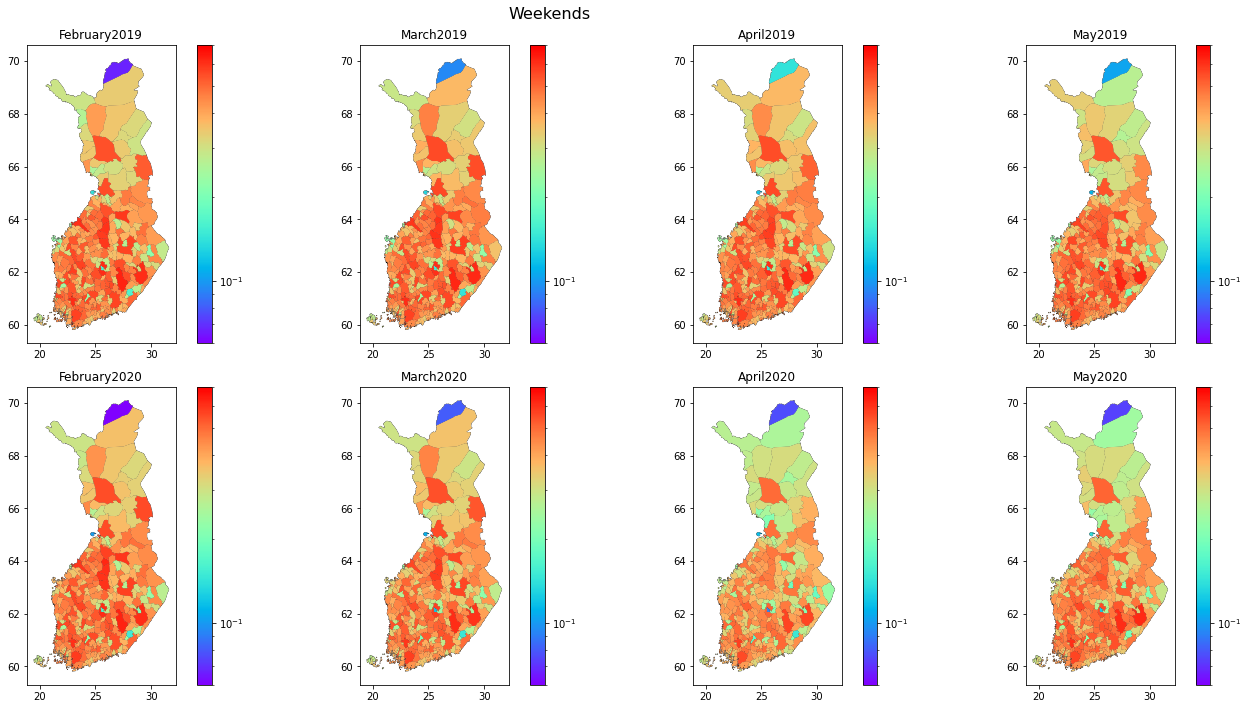

In [96]:
titles = [ 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020']
fig, axes = plt.subplots(figsize=(20, 10),ncols=4, nrows=2)
plt.suptitle("Weekends", fontsize=16)
for g,title,axe  in zip(gdf_points_weekend,titles,axes.flat):
    ax = gdf_municipality.plot(ax = axe, facecolor='white', edgecolor='black', linewidth=0.5)
    gdf_total = gdf_municipality.merge(g[['id','signiture_entropy']], on=['id'])
    gdf_total.plot(ax=ax,
                          column='signiture_entropy', cmap='rainbow', legend=True,
                          norm=matplotlib.colors.LogNorm(vmin=0.06, vmax=0.7))#,alpha=0.5)
    ax.set_title(title)
    plt.tight_layout()


In [ ]:
all_means_weekday = gini_weekdays
all_means_weekend = gini_weekends
tic = ( 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020')
ind = np.arange(8)
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average Gini index')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
ax.set_ylim([0.0,1.15])
plt.grid(True)

plt.savefig('../plots2/f_average_gini.pdf', bbox_inches='tight')

In [200]:
.mean(gini_weekday[2].values())

AttributeError: 'dict_values' object has no attribute 'mean'

In [ ]:
all_means_weekday = [gdf_points_weekdays[i].gyration.mean() for i in range(8)]
all_means_weekend = [gdf_points_weekend[i].gyration.mean() for i in range(8)]
tic = ( 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020')
ind = np.arange(8)
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average gyration')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
#ax.set_ylim([0.003,0.0055])
plt.grid(True)

plt.savefig('../plots2/average_gyration.pdf', bbox_inches='tight')

In [ ]:
all_means_weekday = [gdf_points_weekdays[i].signiture_entropy.mean() for i in range(8)]
all_means_weekend = [gdf_points_weekend[i].signiture_entropy.mean() for i in range(8)]
tic = ( 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020')
ind = np.arange(8)
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Entropy')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
ax.set_ylim([0.0,0.5])
plt.grid(True)

plt.savefig('../plots2/entropy.pdf', bbox_inches='tight')

In [ ]:
all_means_weekday = all_entropy_weekday
all_means_weekend = all_entropy_weekend
tic = ( 'February2019', 'March2019', 'April2019', 'May2019','February2020', 'March2020', 'April2020', 'May2020')
ind = np.arange(8)
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rects1 = ax.bar(ind, all_means_weekday, width, color='royalblue')
rects2 = ax.bar(ind+width, all_means_weekend, width, color='seagreen')

ax.set_ylabel('Average entropy')
ax.set_xticklabels( tic) 
ax.set_xticks(ind + width / 2)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(labels=['weekday', 'weekend'])
plt.tight_layout()
ax.set_ylim([2,2.4])
plt.grid(True)

plt.savefig('average_entropy.pdf', bbox_inches='tight')

In [ ]:
color_city_group_dict = {}
for color in group['leaves_color_list']:
    ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
    color_city_group_dict[color]= [group['ivl'][i] for i in ind]
group_coord = {}
for color in color_city_group_dict.keys():
    cities = color_city_group_dict[color]
    group_coord[color] = [list(municipality_dict.keys())[list(municipality_dict.values()).index(city)] for city in cities]   
group_coord_list = list(group_coord.values())
colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
          ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
          'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
          'Teal','Tomato','Violet']

In [ ]:
for i in range(len(group_coord_list)):    
    ax = gdf_municipality.plot(facecolor='white', edgecolor='black', figsize=(10, 25))
    for x, y, label in zip(gdf_municipality_centroid.lon,gdf_municipality_centroid.lat, gdf_municipality_centroid.code):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    for city, color in zip(group_coord_list[i],colors):
        mobility_network[mobility_network.origin_muni_code == city].sort_values('norm_flow').plot(ax=ax, 
                                                                                     column='norm_flow', color = color, vmax=0.05, vmin=0, alpha = 0.1)

In [ ]:
def plot_signature_gini(df,title):
    plt.figure(figsize=(4, 3))
    
    results = []
    for code in municipalities:
        
        select_truth = df[df.origin_muni_code == code]
        signature_truth = get_destino_distribution2(df,code)
        g3 = round(gini_coefficient(signature_truth.norm_weight),2)
        results.append(g3)
    results = np.array(results)
    plt.hist(results, alpha=0.5, bins=np.linspace(0.6, 1, 21), density=True)
    plt.xlabel('GINI')
    plt.ylabel('Frecuency')
    plt.grid(True)
    plt.title(title)
    plt.tight_layout()


In [ ]:
def plot_gini_entropy(df):    
    results_gini = []
    results_ent = []

    for code in municipalities:

        signature_truth = get_destino_distribution2(df,code)
        g3 = round(gini_coefficient(signature_truth.norm_weight),2)
        e3 = round(entropy(signature_truth.norm_weight),2)
        results_gini.append(g3)
        results_ent.append(e3)


    plt.scatter(results_gini,results_ent, alpha=0.5)
    plt.xlabel('GINI')
    plt.ylabel('Entropy')
    plt.grid(True)
    plt.show()
    plt.tight_layout()

### How can I make the difference plot? Flow of commuter in feb 2020 - feb 2019 ?

In [ ]:

mobility_network1 = mobility_network_weekdays[0] # feb 2019
mobility_network2 = mobility_network_weekdays[5] # feb 2020

ax = gdf_municipality.plot(facecolor='white', edgecolor='black', figsize=(25, 10))

mobility_network1[mobility_network1.origin_muni_code == '049'].sort_values('norm_flow').plot(ax=ax, column='norm_flow',color = 'r', vmax=0.05, vmin=0, alpha = 0.1)
mobility_network2[mobility_network2.origin_muni_code == '049'].sort_values('norm_flow').plot(ax=ax, column='norm_flow',color = 'b', vmax=0.05, vmin=0, alpha = 0.1)